# DATA MANAGEMENT AND EDA

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats as st
import scipy.stats as stats 
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
import math
import os

url = r"/Users/thomas/Documents/Ironhack_final_project/Churn_Modelling.csv"

df = pd.read_csv(url)

In [8]:
############# Data management  ############

df.columns = df.columns.str.lower()

df_minus = df.drop("rownumber", axis=1)

# dataset presentation
# This dataset contains customer information from a bank
# including demographics like **Credit Score**, **Geography**, **Gender**, and **Age**, along with financial details like **Balance** and **Estimated Salary**
# The primary objective is to predict the binary target variable, **'Exited' (1)**
# which indicates whether a customer has **closed their bank account (left the bank)** or remains a customer **(0)**
# This allows for churn prediction analysis.

# Variable Name  |	Description
# Customer_id       The customer's id
# Surname           The customer's surname
# CreditScore	    The customer's creditworthiness score, as assessed by the bank.
# Geography	        The customer's country of residence, being either France, Spain, or Germany.
# Gender	        The customer's sex, categorized as Female or Male.
# Age	            The customer's current age in years.
# Tenure	        The number of years the customer has been with the bank (contract duration).
# Balance	        The customer's account balance in their local currency.
# NumOfProducts	    The number of banking products (e.g., saving account, loan) the customer currently holds.
# HasCrCard	        A binary indicator (1=Yes, 0=No) of whether the customer has a credit card with the bank.
# IsActiveMember	A binary indicator (1=Yes, 0=No) of whether the customer is considered an active member of the bank.
# EstimatedSalary	The estimated annual salary of the customer.
# Exited	        The target variable (1=Left the bank/Churned, 0=Remained a customer)

In [9]:
############# EDA  ############

null_values = df_minus.isna().sum() # 0 null values

duplicates_values = df_minus.duplicated().sum() # 0 duplicates values

nber_customer_id = df["customerid"].nunique() # 10 000 diferent customer_id

# let's drop the customer's surname because it will not help us in the prediction

df_consistent_variable = df_minus.drop("surname", axis=1)

In [10]:
# let's try first to create a classification without using transforme the variables
# And let's use a non linear model wich can handle the imbalance !

# Split Dataset to create few dataframes

In [11]:
customer_dim = df[["customerid", "surname"]]
demographic_dim = df[["customerid", "gender", "geography", "age"]]
bank_relationship_report = df[["customerid", "tenure", "exited"]]
financial_report = df[["customerid","estimatedsalary", "balance", "isactivemember", "numofproducts", "hascrcard", "creditscore"]]


In [12]:

# path
path = r"/Users/thomas/Documents/Ironhack_final_project/Database/"

# Vérification (et création) du dossier si celui-ci n'existe pas
os.makedirs(path, exist_ok=True)
print(f"Dossier de sauvegarde : {path}")


# 1. Export customer_dim
csv1 = "customer_dim.csv"
path1 = os.path.join(path, csv1)
customer_dim.to_csv(path1,sep=";",encoding="utf-8", index=False)

# 2. Export demographic_dim
csv2 = "demographic_dim.csv"
path2 = os.path.join(path, csv2)
demographic_dim.to_csv(path2,sep=";",encoding="utf-8", index=False)

# 3. Export bank_relationship_report
csv3 = "bank_relationship_report.csv"
path3 = os.path.join(path, csv3)
bank_relationship_report.to_csv(path3,sep=";",encoding="utf-8", index=False)

# 4. Export financial_report
csv4 = "financial_report.csv"
path4 = os.path.join(path, csv4)
financial_report.to_csv(path4,sep=";",encoding="utf-8", index=False)


Dossier de sauvegarde : /Users/thomas/Documents/Ironhack_final_project/Database/


# API Development and Exposing Data via API

"""
from flask import Flask, jsonify, request
import pandas as pd
import math

app = Flask(__name__)

# --- DATA LOADING AND PREPARATION ---

DATA_PATH = "/Users/thomas/Documents/Ironhack_final_project/Churn_Modelling.csv" 

try:
    df = pd.read_csv(DATA_PATH)
    df.columns = df.columns.str.lower()
    
    full_customer_data = df.copy()
    
   # Separate dimension tables (as requested by user)
    customer_dim = df[["customerid", "surname"]]
    demographic_dim = df[["customerid", "gender", "geography", "age"]]
    bank_report = df[["customerid", "tenure", "exited"]]
    fin_report = df[["customerid", "estimatedsalary", "balance", "isactivemember", "numofproducts", "hascrcard", "creditscore"]]

except FileNotFoundError:
    print(f"\nFATAL ERROR: Data file not found at path: {DATA_PATH}")
    print("Please check the file path and ensure the file exists.")
    raise # Force l'arrêt du Kernel avec une erreur claire si le fichier est manquant
except Exception as e:
    print(f"General data loading error: {e}")
    raise
    
# ==========================================
# RESOURCE 1: CUSTOMERS (RESTful Resource)
# ==========================================

# Endpoint 1: Collection with Pagination & Filters
@app.route('/api/customers', methods=['GET'])
def get_customers():
    """Returns a paginated list of customers with optional demographic/churn filters."""
    if full_customer_data is None: return jsonify({"error": "No data loaded"}), 500

    # 1. Filtering (e.g., ?geography=France&exited=1)
    filtered_df = full_customer_data.copy()
    
    geo_filter = request.args.get('geography')
    if geo_filter:
        filtered_df = filtered_df[filtered_df['geography'] == geo_filter]
        
    exited_filter = request.args.get('exited')
    if exited_filter:
        # Note: 'exited' is an integer column
        filtered_df = filtered_df[filtered_df['exited'] == int(exited_filter)]

    # 2. Pagination (e.g., ?page=1&per_page=10)
    page = request.args.get('page', 1, type=int)
    per_page = request.args.get('per_page', 10, type=int)
    
    total_items = len(filtered_df)
    # Calculate total pages, handle division by zero safely
    total_pages = math.ceil(total_items / per_page) if per_page > 0 else 0
    
    start = (page - 1) * per_page
    end = start + per_page
    
    # Slicing the data for the current page
    paginated_data = filtered_df.iloc[start:end]

    return jsonify({
        "resource": "customers",
        "total_items": total_items,
        "total_pages": total_pages,
        "current_page": page,
        "per_page": per_page,
        "data": paginated_data.to_dict(orient='records')
    })

# Endpoint 2: Single Object with Nested Details
@app.route('/api/customers/<int:customer_id>', methods=['GET'])
def get_one_customer(customer_id):
    """Returns detailed information for a single customer, combining data from all dimension tables (Nesting)."""
    
    # Basic search
    cust = customer_dim[customer_dim['customerid'] == customer_id]
    if cust.empty: return jsonify({"error": "Customer not found"}), 404
    
    # Retrieve scattered info (Manual Nesting)
    # .iloc[0] is safe because customerid is unique
    demo = demographic_dim[demographic_dim['customerid'] == customer_id].iloc[0]
    bank = bank_report[bank_report['customerid'] == customer_id].iloc[0]
    fin = fin_report[fin_report['customerid'] == customer_id].iloc[0]
    
    # JSON construction with data type casting for clean output
    response = {
        "identity": {
            "id": int(cust.iloc[0]['customerid']),
            "surname": cust.iloc[0]['surname']
        },
        "demographics": {
            "age": int(demo['age']),
            "gender": demo['gender'],
            "geography": demo['geography']
        },
        "financial_status": {
            "balance": float(fin['balance']),
            "salary": float(fin['estimatedsalary']),
            "products_count": int(fin['numofproducts']),
            "credit_score": int(fin['creditscore'])
        },
        "bank_relation": {
            "churned": bool(bank['exited']),
            "tenure": int(bank['tenure'])
        }
    }
    return jsonify(response)

# ==========================================
# RESOURCE 2: ANALYTICS (Report Queries)
# ==========================================

# Endpoint 3: Collection (List of available reports/Documentation)
@app.route('/api/analytics', methods=['GET'])
def get_analytics_list():
    """Returns a list of the 5 available analysis reports."""
    return jsonify({
        "resource": "analytics",
        "available_reports": [
            {"id": 1, "name": "Churn Rate by Demographics", "description": "Calculate churn rate grouped by Geography and Gender (Query 1)"},
            {"id": 2, "name": "Churn vs Active Profile", "description": "Compare avg age and avg products for churned vs active (Query 2)"},
            {"id": 3, "name": "Active Members Financials", "description": "Compare salary and balance for active vs non-active members (Query 3)"},
            {"id": 4, "name": "Multi-Product Analysis", "description": "Avg balance/tenure for customers with >1 product (Query 4)"},
            {"id": 5, "name": "Churn Age Range", "description": "Max and Min age of churned customers (Query 5)"}
        ]
    })

# Endpoint 4: Single Analysis (Execution of the 5 Pandas queries)
@app.route('/api/analytics/<int:report_id>', methods=['GET'])
def get_analysis_report(report_id):
    """Executes a specific analytical query based on the report_id."""
    
    if full_customer_data is None: return jsonify({"error": "No data loaded"}), 500
    
    data = []
    meta = {}
    res = pd.DataFrame() # Initialize res for type safety

    if report_id == 1:
        # Query 1: Churn Rate by Demographics (Geo & Gender)
        merged = pd.merge(customer_dim, demographic_dim, on="customerid")
        merged = pd.merge(merged, bank_report, on="customerid")
        res = merged.groupby(["geography", "gender"]).agg(
            churn_rate=("exited", "mean"), 
            total_customers=("customerid", "count")
        ).reset_index().sort_values("churn_rate", ascending=False)
        meta = {"description": "Churn rate by geography and gender"}

    elif report_id == 2:
        # Query 2: Avg age and products for churned vs active
        merged = pd.merge(customer_dim, bank_report, on="customerid")
        merged = pd.merge(merged, demographic_dim, on="customerid")
        merged = pd.merge(merged, fin_report, on="customerid")
        res = merged.groupby("exited").agg(
            avg_age=("age", "mean"), 
            avg_num_products=("numofproducts", "mean"),
            total_customers=("customerid", "count")
        ).reset_index()
        meta = {"description": "Avg age and products for churned (1) vs active (0) customers"}

    elif report_id == 3:
        # Query 3: Active Members Financials
        merged = pd.merge(customer_dim, fin_report, on="customerid")
        res = merged.groupby("isactivemember").agg(
            avg_estimated_salary=("estimatedsalary", "mean"),
            avg_balance=("balance", "mean"),
            total_customers=("customerid", "count")
        ).reset_index()
        meta = {"description": "Avg salary and balance for active (1) vs non-active (0) members"}

    elif report_id == 4:
        # Query 4: Multi-Product Analysis
        merged = pd.merge(customer_dim, fin_report, on="customerid")
        merged = pd.merge(merged, bank_report, on="customerid")
        
        # WHERE numofproducts > 1
        filtered = merged[merged["numofproducts"] > 1]
        
        res = filtered.groupby("numofproducts").agg(
            avg_balance=("balance", "mean"),
            avg_tenure=("tenure", "mean"),
            total_customers=("customerid", "count")
        ).reset_index()
        
        # ORDER BY avg_balance DESC
        res = res.sort_values(by="avg_balance", ascending=False)
        meta = {"description": "Balance and Tenure for customers with >1 product, ordered by balance"}

    elif report_id == 5:
        # Query 5: Churn Age Range
        merged = pd.merge(customer_dim, demographic_dim, on="customerid")
        merged = pd.merge(merged, bank_report, on="customerid")
        
        # WHERE exited = 1
        filtered = merged[merged["exited"] == 1]
        
        result_series = filtered.agg(
            max_age_churned=("age", "max"),
            min_age_churned=("age", "min")
        )
        # Convert result Series to DataFrame for consistent output structure
        res = pd.DataFrame([result_series]) 
        meta = {"description": "Min and Max age of churned customers"}
    
    else:
        return jsonify({"error": "Report ID must be between 1 and 5"}), 404

    # Final conversion to list of dicts for JSON output
    data = res.to_dict(orient='records')

    return jsonify({
        "report_id": report_id,
        "meta": meta,
        "results": data
    })

if __name__ == '__main__':
    # Utiliser '0.0.0.0' pour écouter toutes les interfaces réseau
    app.run(debug=True, use_reloader=False, port=5001, host='0.0.0.0')
"""

In [13]:
# --- A. Test Ressource 1: Customers (Pagination & Filters) ---
import requests
BASE_URL = "http://127.0.0.1:5001/api"

print("--- TEST A: Clients (Page 2, 5 par page, filtré France) ---")
params = {
    "page": 2,
    "per_page": 5,
    "geography": "France"
}

response_customers = requests.get(f"{BASE_URL}/customers", params=params)

if response_customers.status_code == 200:
    data = response_customers.json()
    print(f"Statut: OK (200). Total clients filtrés: {data['total_items']}")
    print(f"Premiers résultats de la page {data['current_page']}:")
    
    df_customers = pd.DataFrame(data['data'])
    print(df_customers.head(2)) 
else:
    print(f"Erreur lors de l'appel Customers: {response_customers.status_code}")
    print(response_customers.json())

print("\n" + "="*50 + "\n")

--- TEST A: Clients (Page 2, 5 par page, filtré France) ---
Statut: OK (200). Total clients filtrés: 5014
Premiers résultats de la page 2:
   age    balance  creditscore  customerid  estimatedsalary  exited gender  \
0   27  134603.88          684    15592389         71725.73       0   Male   
1   31  102016.72          528    15767821         80181.12       0   Male   

  geography  hascrcard  isactivemember  numofproducts  rownumber surname  \
0    France          1               1              1         10      H?   
1    France          0               0              2         11  Bearce   

   tenure  
0       2  
1       6  




In [14]:
import requests
import pandas as pd
import json

# The base URL now points to port 5001
BASE_URL = "http://127.0.0.1:5001/api" 

print("=========================================")
print("     TESTING THE 4 MAIN ENDPOINTS")
print("=========================================")


# 1. TEST COLLECTION & FILTERS: /api/customers
# ----------------------------------------------
print("\n### 1. CUSTOMERS (Filtering and Pagination)")
params = {
    "page": 2,
    "per_page": 5,
    "geography": "France"
}

response_customers = requests.get(f"{BASE_URL}/customers", params=params)

if response_customers.status_code == 200:
    data = response_customers.json()
    print(f"Status: OK (200). Total filtered customers (France): {data['total_items']}")
    print(f"Current page: {data['current_page']}")
    
    # Display results in a DataFrame for better clarity
    df_customers = pd.DataFrame(data['data'])
    print("First results on the page:")
    print(df_customers[['customerid', 'surname', 'geography', 'age']].head())
else:
    print(f"!!! CUSTOMERS FAILED !!! Code: {response_customers.status_code}")
    print(response_customers.json())

print("\n" + "-"*50)

# 2. TEST SINGLE OBJECT (NESTING): /api/customers/<id>
# ----------------------------------------------------
print("\n### 2. SINGLE CUSTOMER (Nested Details)")
CUSTOMER_ID = 15637281 # A valid customer ID

response_single = requests.get(f"{BASE_URL}/customers/{CUSTOMER_ID}")

if response_single.status_code == 200:
    data = response_single.json()
    print(f"Status: OK (200). Details for {data['identity']['surname']}:")
    
    # Displaying nested data to check the structure
    print(f"  > Age: {data['demographics']['age']}")
    print(f"  > Balance: {data['financial_status']['balance']:.2f}")
    print(f"  > Churn: {data['bank_relation']['churned']}")
else:
    print(f"!!! SINGLE CUSTOMER FAILED !!! Code: {response_single.status_code}")
    print(response_single.json())

print("\n" + "-"*50)

# 3. TEST ANALYTICS LIST: /api/analytics
# --------------------------------------
print("\n### 3. ANALYTICS LIST (List of Reports)")
response_list = requests.get(f"{BASE_URL}/analytics")

if response_list.status_code == 200:
    data = response_list.json()
    print(f"Status: OK (200). Number of available reports: {len(data['available_reports'])}")
    print(f"Report #4 Name: {data['available_reports'][3]['name']}")
else:
    print(f"!!! ANALYTICS LIST FAILED !!! Code: {response_list.status_code}")


# 4. TEST SINGLE ANALYSIS (EXECUTION): /api/analytics/4
# ----------------------------------------------------
print("\n### 4. ANALYTICS EXECUTION (Query 4 - Multi-Product)")
REPORT_ID = 4 
response_report = requests.get(f"{BASE_URL}/analytics/{REPORT_ID}")

if response_report.status_code == 200:
    data = response_report.json()
    print(f"Status: OK (200). Report ID {REPORT_ID} loaded.")
    
    df_report = pd.DataFrame(data['results'])
    print(f"Description: {data['meta']['description']}")
    print("Query Result (Avg Balance by number of products):")
    print(df_report)
else:
    print(f"!!! ANALYTICS EXECUTION FAILED !!! Code: {response_report.status_code}")
    print(response_report.json())

print("\n=========================================")

     TESTING THE 4 MAIN ENDPOINTS

### 1. CUSTOMERS (Filtering and Pagination)
Status: OK (200). Total filtered customers (France): 5014
Current page: 2
First results on the page:
   customerid surname geography  age
0    15592389      H?    France   27
1    15767821  Bearce    France   31
2    15632264     Kay    France   34
3    15691483    Chin    France   25
4    15568982     Hao    France   24

--------------------------------------------------

### 2. SINGLE CUSTOMER (Nested Details)
!!! SINGLE CUSTOMER FAILED !!! Code: 404
{'error': 'Customer not found'}

--------------------------------------------------

### 3. ANALYTICS LIST (List of Reports)
Status: OK (200). Number of available reports: 5
Report #4 Name: Multi-Product Analysis

### 4. ANALYTICS EXECUTION (Query 4 - Multi-Product)
Status: OK (200). Report ID 4 loaded.
Description: Balance and Tenure for customers with >1 product, ordered by balance
Query Result (Avg Balance by number of products):
    avg_balance  avg_tenure

In [15]:
# Variable Configuration (to be verified)
import requests
BASE_URL = "http://127.0.0.1:5001/api" 
CUSTOMER_ID = 15592389  # <--- REPLACE WITH YOUR SPECIFIC ID

# 2. TEST SINGLE OBJECT (NESTING): /api/customers/<id>
# ----------------------------------------------------
print("\n### 2. UNIQUE CUSTOMER (Nested Details)")

response_single = requests.get(f"{BASE_URL}/customers/{CUSTOMER_ID}")

if response_single.status_code == 200:
    data = response_single.json()
    print(f"Status: OK (200). Details for {data.get('identity', {}).get('surname', 'N/A')}:")
    
    # Displaying nested data to verify the structure
    print(f"  > First Name: {data.get('identity', {}).get('firstname', 'N/A')}")
    print(f"  > Age: {data.get('demographics', {}).get('age', 'N/A')}")
    print(f"  > Balance: {data.get('financial_status', {}).get('balance', 'N/A')}")
    print(f"  > Churn: {data.get('bank_relation', {}).get('churned', 'N/A')}")
else:
    print(f"!!! SINGLE CUSTOMER FAILED !!! Code: {response_single.status_code}")
    try:
        print(response_single.json())
    except requests.exceptions.JSONDecodeError:
        print(response_single.text)

print("\n" + "="*50)


### 2. UNIQUE CUSTOMER (Nested Details)
Status: OK (200). Details for H?:
  > First Name: N/A
  > Age: 27
  > Balance: 134603.88
  > Churn: False



# Statistical Analysis

In [16]:
# The purpose of the analysis is to define witch variables have relation with the target one
# We are suppose to keep only the variables wich have relation with exited to train the model  

#### check target variable : exited ####
values_count_exited = df_consistent_variable["exited"].value_counts()
# +------+-----+
# |exited|count|
# +------+-----+
# |     1| 2037|
# |     0| 7963|
# +------+-----+

## Creditscores

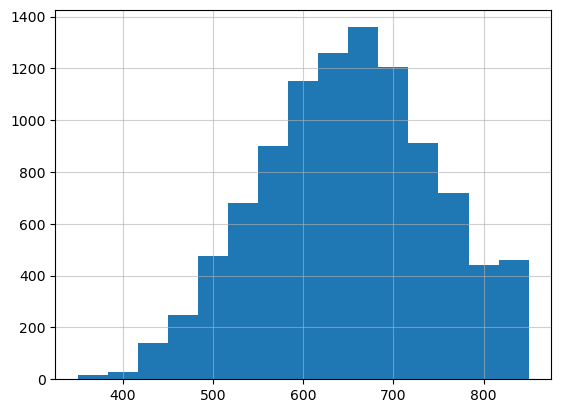

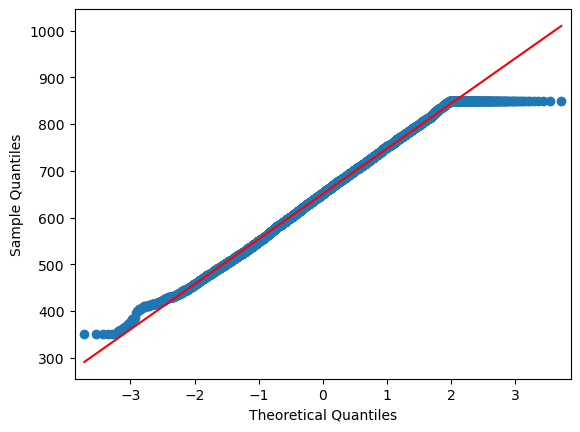

In [17]:
############# Checking all columns and their relationship with exited #############

#### check creditscore ####
# They measure a borrower's ability to repay debts based on their financial history. 
# Here's what the credit score reflects for a bank

# does it folowing a normal distribution ?

creditscores = df_consistent_variable["creditscore"]
plt.hist(creditscores, bins=15)
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

creditscores_qqplot = np.array(creditscores)

sm.qqplot(creditscores_qqplot, line='s')
plt.show()

/Library/AppStore/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/w8/cwyb0nss18l02_7tzc265m1c0000gn/T/ipykernel_73372/1931531537.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_consistent_variable, x='exited', y='creditscore', palette="coolwarm")


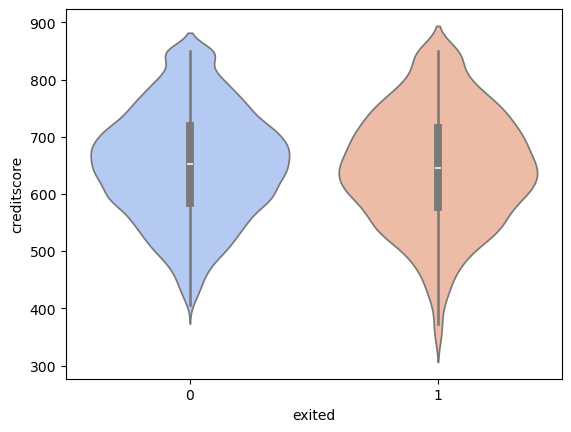

In [18]:
# creditscore seems almost folowing a normal distribution
# we can conclude we have less high values than expected and a bit more low values that expected

# let's try to confirm that creditscore folow a normal distribution thanks to the shapiro-wilk test
# H0 : creditscore folow a normal distribution
# H1 : creditscore doesn't folow a normal distribution

stat, p_value = st.shapiro(creditscores)

# p_value = 3.470965102195033e-20
# H0 is rejected, creditscore doesn't folow a normal distribution

# Does exist a relationship between creditscore and exited ? 
# let's folow the CLT hypothesis wich mean that every distribution with n>30 folow a normal distribution
# Thanks to that we will be able to use t test and not a non parametric test like Mann-Whitney

exited_0_std = df_consistent_variable[df_consistent_variable["exited"]==0]["creditscore"].std() # = 95.65
exited_1_std = df_consistent_variable[df_consistent_variable["exited"]==1]["creditscore"].std() # = 100.32

# the variance between both is not equal
# we can use the test as equal_var=False

creditscore_exited = df_consistent_variable[["creditscore", "exited"]]
exited_0 = df_consistent_variable[df_consistent_variable["exited"]==0]["creditscore"]
exited_1 = df_consistent_variable[df_consistent_variable["exited"]==1]["creditscore"]

# H0 : mu extited_0 = mu exited1
# H1 : mu extited_0 != mu exited1

stats, p_value = st.ttest_ind(exited_0, exited_1, alternative='two-sided',equal_var = False)
# p_value = 0.0084 < 0.05 & stats = 2.63
# H0 is rejected, so mu extited_0 != mu exited1
# So we can say that we have a significal distinction but the heavy of it can depend because the diference is not high

sns.violinplot(data=df_consistent_variable, x='exited', y='creditscore', palette="coolwarm")
plt.show()


In [19]:
# It clearly seems that we don't have a enought significal diference between
# creditscore and exited to use it 

# let's see if the relationship between exited and creditscore is diferent by grouping creditscore into bins 
# Let's have a look on creditscore distribution

# df_consistent_variable.select("creditscore").describe().show()
# max = 850, min = 350

# let's say that under 550 : the customer's creditscore is low
# between 551 and 700 : the customer's creditscore is medium
# above 700 : the customer's creditscore is high


def cat_creditscores(row):
    if row < 550:
        return 'low CS'
    elif row >= 550 and row < 700 :
        return 'medium CS'
    else :
        return 'high CS'

df_consistent_variable['creditscore'] = df_consistent_variable['creditscore'].apply(cat_creditscores)

creditscore_distrib = df_consistent_variable['creditscore'].value_counts()

# creditscore_distrib
# medium CS    5262
# high CS      3148
# low CS       1590

In [20]:
# let's check quickly the average chance for a each creditscore to exited
credit_score_cat_average_chance_to_exit = df_consistent_variable.groupby("creditscore").agg({"exited": "mean"})

# +-----------+-------------------+
# |creditscore|        avg(exited)|
# +-----------+-------------------+
# |    high CS|0.19822109275730623|
# |     low CS| 0.2270440251572327|
# |  medium CS| 0.1999239832763208|
# +-----------+-------------------+

# it seems that we don't have a significant relationship between high and medium CS
# let's confirm that and group them if they don't have a significant diference

churn_highcs = df_consistent_variable[(df_consistent_variable["creditscore"]=="high CS")&(df_consistent_variable["exited"]==1)]["creditscore"].count()
total_highcs = df_consistent_variable[df_consistent_variable["creditscore"]=="high CS"]["creditscore"].count()

churn_mediumcs = df_consistent_variable[(df_consistent_variable["creditscore"]=="medium CS")&(df_consistent_variable["exited"]==1)]["creditscore"].count()
total_mediumcs = df_consistent_variable[df_consistent_variable["creditscore"]=="medium CS"]["creditscore"].count()

# H0 : we don't have a significant diference
# H1 : we do have a significant diference

stats, p_value = proportions_ztest([churn_highcs, churn_mediumcs], [total_highcs, total_mediumcs])
# p_value = 0.849941935430545
# H0 is accepted, we don't have a significant relationship

# let's group them

def group_creditscore(row):
    if row == "low CS":
        return "low CS"
    else :
        return "medium-high CS"
        
df_consistent_variable["creditscore"] = df_consistent_variable["creditscore"].apply(group_creditscore)

# # let's see now if we have a significant relationship between low CS and medium-high CS

churn_lowcs = df_consistent_variable[(df_consistent_variable["creditscore"]=="low CS")&(df_consistent_variable["exited"]==1)]["creditscore"].count()
total_lowcs = df_consistent_variable[df_consistent_variable["creditscore"]=="low CS"]["creditscore"].count()

churn_medhigcs = df_consistent_variable[(df_consistent_variable["creditscore"]=="medium-high CS")&(df_consistent_variable["exited"]==1)]["creditscore"].count()
total_medhigcs = df_consistent_variable[df_consistent_variable["creditscore"]=="medium-high CS"]["creditscore"].count()
# H0 : we don't have a significant diference
# H1 : we do have a significant diference

stats, p_val = proportions_ztest([churn_lowcs, churn_medhigcs], [total_lowcs, total_medhigcs])
# p_val = 0.011727380893578838 < 0.05
# H0 is rejected, we have a significant diference between churn_lowcs and churn_medhigcs

# # let's now convert this categorical variable as ordinal

df_consistent_variable["creditscore"] = np.where(df_consistent_variable["creditscore"] == 'low CS', 1, 0)

## Geography

In [21]:
#### check geography ####

# 3 diferents geography where can from the customers : France, Spain, Germany

# Does geography and exited have a relationship ? 
# Let's see that with a chi test

# H0 : variables are independants
# H1 : variables are dependant

tableau_contingence = pd.crosstab(df_consistent_variable['geography'], df_consistent_variable['exited'])

chi2_stat, p_value, dof, expected_freq = chi2_contingency(tableau_contingence)

# pvalues = 3.83e-66 < 0.05
# H0 is rejected, we have a significantly relation between both variable

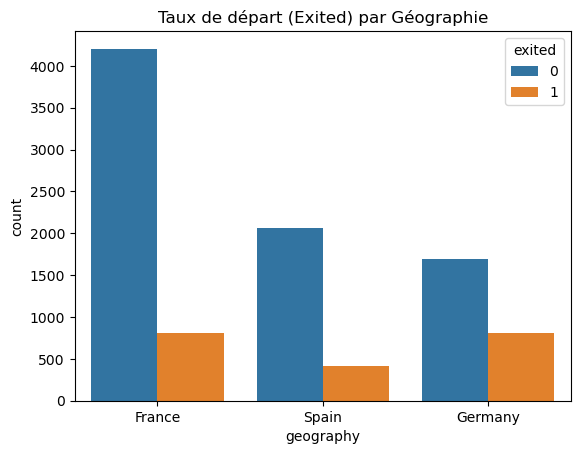

In [22]:
# let's try to see the strength of it 

n = df_consistent_variable.shape[0]
k1 = df_consistent_variable['geography'].nunique()
k2 = df_consistent_variable['exited'].nunique()

# Calcul de V de Cramer
cramers_v = math.sqrt(chi2_stat / n / min(k1 - 1, k2 - 1))

# cramers_v = 0.17 so we have a moderate relation between geography and exited

# Visualisation
sns.countplot(data=df_consistent_variable, x="geography", hue="exited")
plt.title('Taux de départ (Exited) par Géographie')
plt.show()

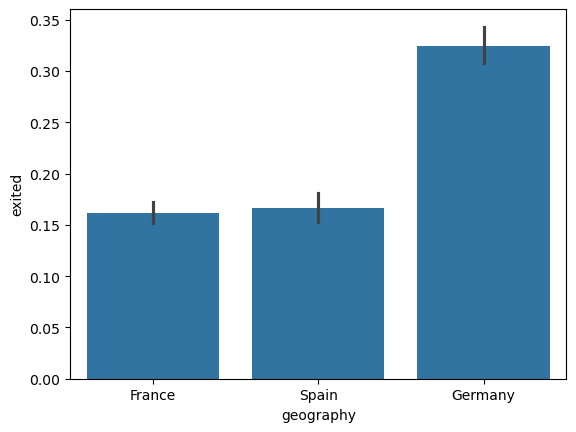

In [23]:
# we can approximatly see here that in proprotion, german customer leave more than french or spanish 

# let's see this proportion with a barplot

sns.barplot(data=df_consistent_variable, x='geography', y='exited')
plt.show()

In [24]:
# we can effectivly say that if the customer come from germany, he have around 2 times more
# luck to leave
# it's also seems that french and spanish have the same proportion of leaving

# let's try to confirm that with a z-test

# H0 : both geography don't have a significal diferent proportion
# H1 : both geography have a significal diferent proportion

# #group_france_spain = df.groupby(["geography", "exited"]).count().filter(col("geography").isin(["France", "Spain"]))
# df_france_spain_pandas = df_consistent_variable.groupby(["geography", "exited"]).count()
# df_france_spain_pandas
# # group_france_spain.toPandas()

churn_france = df_consistent_variable[(df_consistent_variable["exited"] == 1) & (df_consistent_variable["geography"] == "France")]["geography"].count()
total_france = df_consistent_variable[df_consistent_variable["geography"] == "France"]["geography"].count()

churn_spain = df_consistent_variable[(df_consistent_variable["exited"] == 1) & (df_consistent_variable["geography"] == "Spain")]["geography"].count()
total_spain = df_consistent_variable[df_consistent_variable["geography"] == "Spain"]["geography"].count()

stats, p_value = proportions_ztest([churn_france,churn_spain], [total_france, total_spain], alternative = "two-sided")
# p_value = 0.56 > 0.05
# H0 is accepted, so we can say that both geography don't have a significal diferent proportion
# So we don't have a statistical diference between the proportion of churn of those both geography
# With the aim to have the best prediction, to reduce de complexity and the noise, we will group both 
# geography in a unique one


df_consistent_variable["geography"] = np.where(df_consistent_variable["geography"]=='Germany', 'Germany', 'France-Spain')

# +------------+-----+
# |   geography|count|
# +------------+-----+
# |     Germany| 2509|
# |France-Spain| 7491|
# +------------+-----+

# we can see here that we have now more values in France-Spain 
# Does this diference will influence our prediction model ? 
# No because the germany count is enought high to alow the model to leran about it
# And moreover we will use a model that handle the imbalance 

# We will use OneHotEncoder later on this column because she is nominal

## Gender

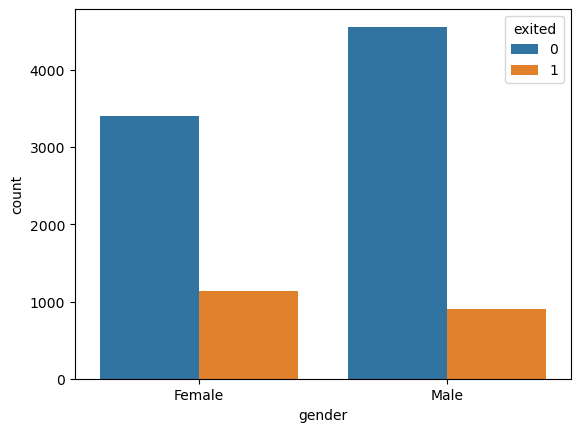

In [25]:
#### check gender ####

df_consistent_variable["gender"].value_counts()

# |Female| 4543|
# |  Male| 5457|

# we can see that we have more male than female but it will not influence our prediction model 

# let's see if we have a significantly relationship between gender and exited

# H0 : variables are independants
# H1 : we have a significantly relation between both variable

tableau_contingence = pd.crosstab(df_consistent_variable['gender'], df_consistent_variable['exited'])

# Exécute le test Chi-Carré. Nous avons besoin de la statistique chi2 (stats) et de la p_value.
chi2_stat, p_value, dof, expected_freq = chi2_contingency(tableau_contingence)

# # pValues = 0.0 < 0.05
# # So H0 is rejected, we have a significantly relation between both variable

# # let's see their strenght 
stats = chi2_stat
n = df_consistent_variable.shape[0]
k1 = df_consistent_variable['gender'].nunique()
k2 = df_consistent_variable['exited'].nunique() 

cramers_v = math.sqrt(stats / n / min(k1 - 1, k2 - 1))
# cramers_v = 0.1063 > 0.1 and <0.3 so we have a moderate relation

sns.countplot(data=df_consistent_variable, x="gender", hue="exited")
plt.show()


In [26]:
# thanks to this visualisation we can see that in proportion Female tend to leave 
# more than men 

# let's try to confirm that with a z-test

# H0 : both gender don't have a significantly diferent proportion
# H1 : both gender have a significantly diferent proportion

churn_male = df_consistent_variable[(df_consistent_variable["exited"] == 1) & (df_consistent_variable["gender"] == "Male")]["gender"].count()
total_male = df_consistent_variable[df_consistent_variable["gender"] == "Male"]["gender"].count()

churn_female = df_consistent_variable[(df_consistent_variable["exited"] == 1) & (df_consistent_variable["gender"] == "Female")]["gender"].count()
total_female = df_consistent_variable[df_consistent_variable["gender"] == "Female"]["gender"].count()

stats, p_value = proportions_ztest([churn_male,churn_female], [total_male, total_female], alternative = "two-sided")

# p_value = 1.720414987484119e-26.56 < 0.05
# H0 is rejected, both geography have a significal diferent proportion

# We will use OneHotEncoder later on this column because she is nominal

## Age

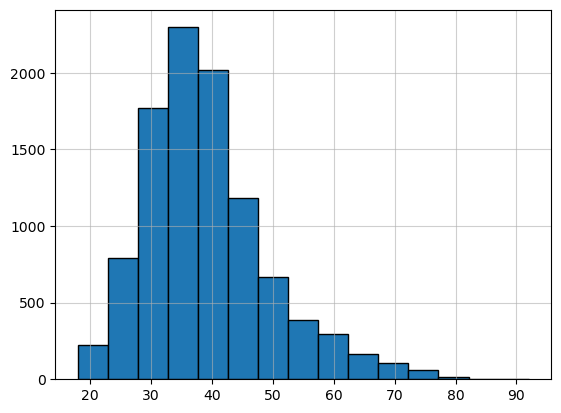

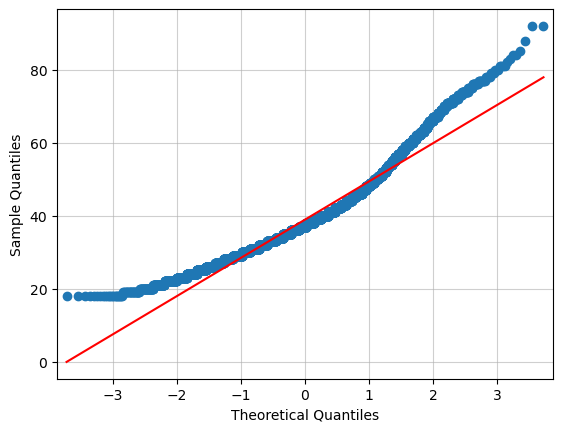

In [27]:
# Does age folowing a normal distribution ? 

ages = df_consistent_variable['age']

plt.hist(ages, bins=15, edgecolor='black')
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

ages_qqplot = np.array(ages)

sm.qqplot(ages_qqplot, line='s')
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

/Library/AppStore/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/w8/cwyb0nss18l02_7tzc265m1c0000gn/T/ipykernel_73372/3996926046.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_consistent_variable, x='exited', y='age', palette="coolwarm")


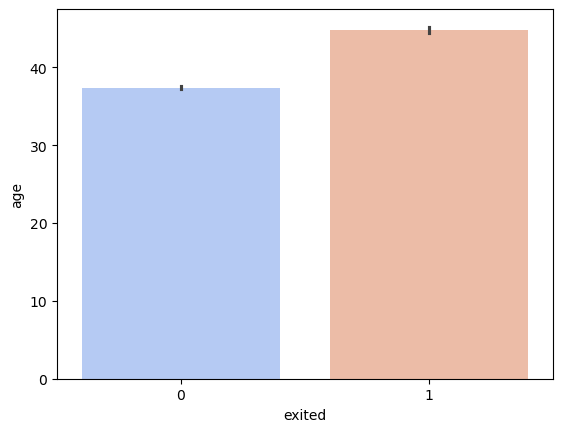

In [28]:
# thanks to this histogram and this qqplot, we can conclude the folowing :
# Age distribution doen't folow a normal distribution 
# Age distribution is on right skewness
# It contain more high values than expected due to a heavy tails
# It contain more low values than expected
# We can also see that most of our customer's age are concentred between 25 and 45

# let's confirm that with a shapiro-wilk test
stat, p_value = st.shapiro(ages)
# p_value = 1.3079365657693273e-51 < 0.05
# We can conclude that p_value doesn't folow a normal distribution

# how many diferent age we have ? 
nbre_val = df_consistent_variable["age"].value_counts()
# we have 70 diferents ages

# let's see now if we have a relation ship between age and exited

# let's visualise now the relation with a violinplot
sns.barplot(data=df_consistent_variable, x='exited', y='age', palette="coolwarm")
plt.show()


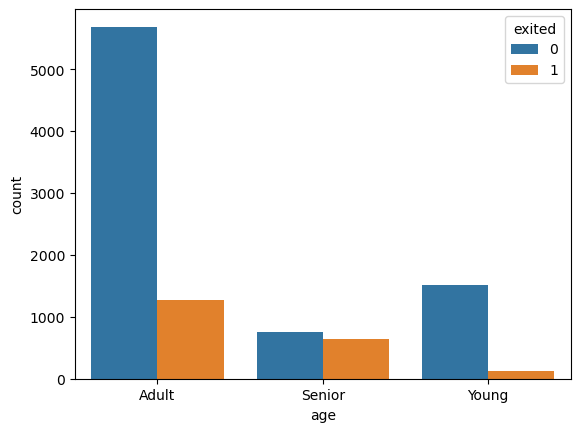

In [29]:
# Thanks to this barplot, we can say that the oldest persons exite more than the youger

# As we folow the CLT hypothesis we can use t test to confirm this diference

# let's confirm that with a t-test

# H0 : there is no diference between both variables
# H1 : there is significantly diference between both variables 

group_age_exited0 = df_consistent_variable[df_consistent_variable["exited"]==0]["age"]
group_age_exited1 = df_consistent_variable[df_consistent_variable["exited"]==1]["age"]

stats, p_value = st.ttest_ind(group_age_exited0, group_age_exited1, alternative='two-sided', equal_var=False)
# p_value = 4.71272727e-179 < 0.05
# H0 is rejected, there is significantly diference between both variables 
# So we have a significantly relationship between age and exited or not

# let's try so see where come from this diference

# let's group by age by the folowing :
# young : 18 - 30, adult : 30 - 50, senior : 50 +

def cat_age(row):
    if row < 30:
        return 'Young'
    elif row >=30 and row < 50:
        return 'Adult'
    else:
        return 'Senior'

df_consistent_variable["age"] = df_consistent_variable["age"].apply(cat_age)
# let's see on a countplot if we can visualise diferent proportion of exited according to the age groups

sns.countplot(data=df_consistent_variable, x="age", hue="exited")
plt.show()

In [30]:
# we can clearly see that the proportion of senior who left is high 
# The proportion of senior who left is almost equal to the count of senior
# the proportion of Adulte who left also seems biggier than the young

# Let's confirm that by using a z-test and analyse the proportion of customers who left between young and adult

adult_churn = df_consistent_variable[(df_consistent_variable["age"]=="Adult")&(df_consistent_variable["exited"]==1)]["age"].count()
total_adult = df_consistent_variable[df_consistent_variable["age"]=="Adult"]["age"].count()

young_churn = df_consistent_variable[(df_consistent_variable["age"]=="Young")&(df_consistent_variable["exited"]==1)]["age"].count()
total_young = df_consistent_variable[df_consistent_variable["age"]=="Young"]["age"].count()

# H0 : Young churn porportion is bigger than Adult churn proportion
# H1 : Adult churn proportion is bigger than Young churn proportion

stats, p_value = proportions_ztest([adult_churn, young_churn], [total_adult, total_young], alternative='larger')
# p_value = 7.520566143653763e-27
# H0 is rejected, Adult churn proportion is bigger than Young churn proportion

## Tenure

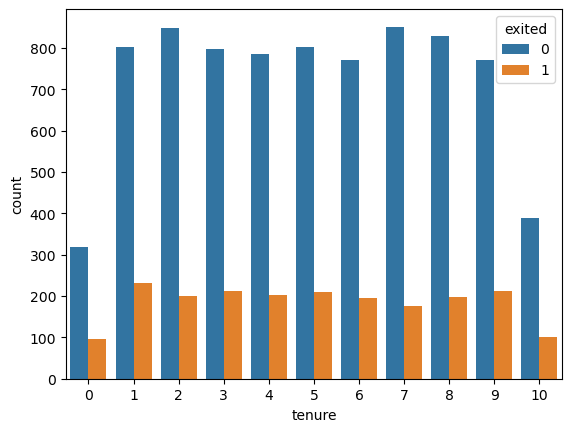

In [31]:

# Customers seniority in years

# check how many diferents years of tenure we have
nbre_tenure = df_consistent_variable["tenure"].value_counts()
# we have 11 diferents years of tenure nbre_tenure

# let's do a chi-square to see if we have a relationship between both variables

# H0 : we don't have a significantly relationship between years of tenure and features
# H0 : we have a significantly relationship between years of tenure and features
tableau_contingence = pd.crosstab(df_consistent_variable['tenure'], df_consistent_variable['exited'])
chi2_stat, p_value, dof, expected_freq = chi2_contingency(tableau_contingence)
# pValues = 0.17 > 0.05
# H0 is accepted, we don't have a significantly relationship between years of tenure and features


# let's confirm that with a countplot
sns.countplot(data=df_consistent_variable, x='tenure', hue='exited')
plt.show()

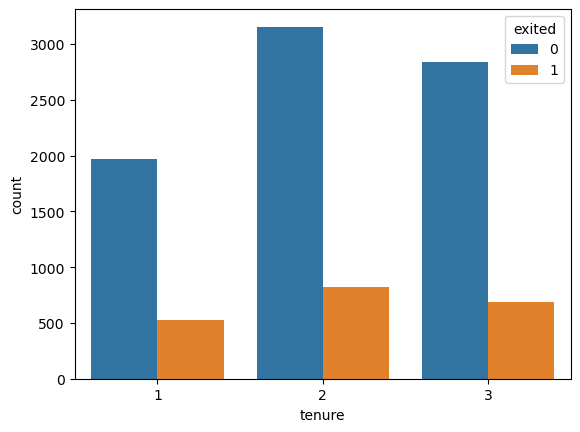

In [32]:
# we effectivly cannot clearly see a diference 
# let's try to group by them by the folowing :
# low-tenure : 0 - 2 => 1 
# mid-tenure : 3 - 6 => 2
# high-tenure : 7 - 10 => 3

#df = df.withColumn("tenure",f.when(col("tenure") < 3, '1').when(col("tenure") > 6, '3').otherwise('2'))
def cat_tenure(row):
    if row <= 2 :
        return 1
    elif row >2 and row <=6 :
        return 2
    else :
        return 3
        
df_consistent_variable["tenure"] = df_consistent_variable["tenure"].apply(cat_tenure)

# let's try to see the countplot again 

sns.countplot(data=df_consistent_variable, x='tenure', hue='exited')
plt.show()

# it seems now to have a diference of churn between those 3 types of tenure
# let's confirm that with a z-test

churn_tenure1 = df_consistent_variable[(df_consistent_variable["tenure"]==1)&(df_consistent_variable["exited"]==1)]["tenure"].count()
total_tenure1 = df_consistent_variable[df_consistent_variable["tenure"]==1]["tenure"].count()

churn_tenure2 = df_consistent_variable[(df_consistent_variable["tenure"]==2)&(df_consistent_variable["exited"]==1)]["tenure"].count()
total_tenure2 = df_consistent_variable[df_consistent_variable["tenure"]==2]["tenure"].count()

churn_tenure3 = df_consistent_variable[(df_consistent_variable["tenure"]==3)&(df_consistent_variable["exited"]==1)]["tenure"].count()
total_tenure3 = df_consistent_variable[df_consistent_variable["tenure"]==3]["tenure"].count()

# # test between churn_tenure1 and churn_tenure2
# H0 : The proportion between both test is not significantly diferent
# H1 : The proportion of the churn tenure 1 is bigger

stat, p_value = proportions_ztest(
    count=[churn_tenure1, churn_tenure2],
    nobs=[total_tenure1, total_tenure2],
    alternative='larger'
)
# p_value = 0.3114114110357198 > 0
# H0 is accepted, the proportion between both test is not significantly diferent

# # So we definely doesn't have a relationship between tenure and extited by categorising the variable 

In [33]:
# Let's double check if we don't have any relationship

# let's confirm that for one : years0 and year 7
# churn_tenure0 = df.select("tenure").filter((col("tenure")==0)&(col("exited")==1)).count()
# total_tenure0 = df.select("tenure").filter(col("tenure")==0).count()

# churn_tenure7 = df.select("tenure").filter((col("tenure")==7)&(col("exited")==1)).count()
# total_tenure7 = df.select("tenure").filter(col("tenure")==7).count()

# stat, p_value = proportions_ztest([churn_tenure0, churn_tenure7], [total_tenure0, total_tenure7], alternative='two-sided')

# p_value = 0.01116970847650959 < 0.05 
# so we will keep tenure to do the prediction

# let's finnaly drop tenure because we get a lower score with the model when we keep it 

df_consistent_variable = df_consistent_variable.drop("tenure", axis=1)

## Balance

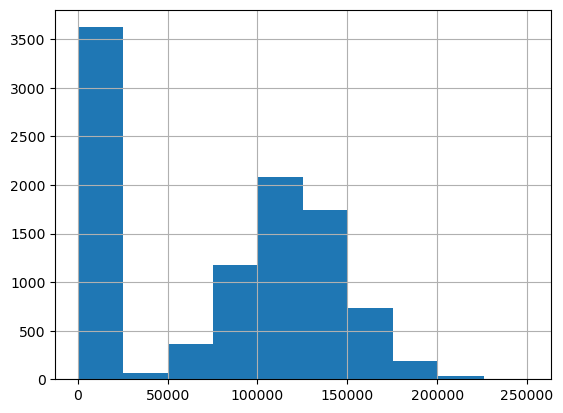

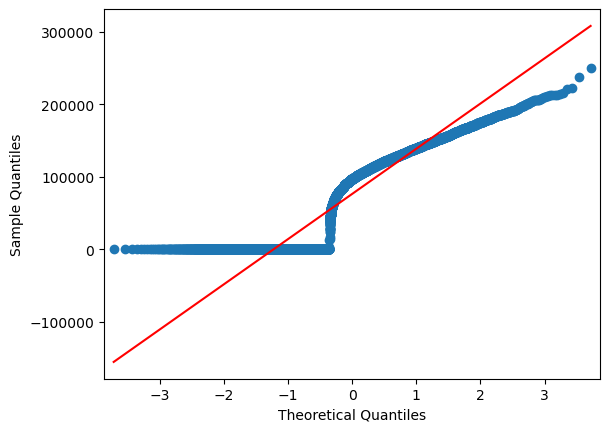

In [34]:
# does balance folowing a normal distribution ? 

balances = df_consistent_variable["balance"]

plt.hist(balances, bins=10)
plt.grid(True, linestyle='-')
plt.show()

balances_qqplot = np.array(balances)

sm.qqplot(balances_qqplot, line='s')
plt.show()

/Library/AppStore/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/w8/cwyb0nss18l02_7tzc265m1c0000gn/T/ipykernel_73372/1027307489.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_consistent_variable, x='exited', y='balance', palette="coolwarm")


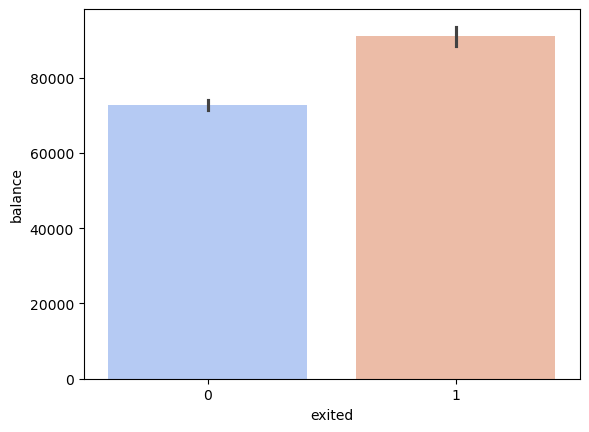

In [35]:
# Here we can see that balance doesn't folow a normal distribution
# Overmore, we can say :
# we have a lot of balance wich are equals to 0, so we have a heavy lower tail
# we have less high values than expected

# let's confirm that with a shapiro-wilk test
# H0 : creditscore folow a normal distribution
# H1 : creditscore doesn't folow a normal distribution

stat, p_value = st.shapiro(balances)
# p_value = 4.288579023389832e-71
# H0 is rejected, creditscore doesn't folow a normal distribution

# do we have a relationship between balance and exited ?

# let's see that with a barplot

# let's visualise now the relation with a violinplot
sns.barplot(data=df_consistent_variable, x='exited', y='balance', palette="coolwarm")
plt.show()

In [36]:
# We can see a diference of balance for customers who's exited and not
# It seem's that customers who left have a highest balance

# let's confirm that with a t-test

# H0 : we don't have a significantly diference between both variables
# H1 : Churn customers balance is bigger than no churn customer balance

balance_exited0 = df_consistent_variable[df_consistent_variable["exited"]==0]["balance"]
balance_exited1 = df_consistent_variable[df_consistent_variable["exited"]==1]["balance"]

stat, p_value = st.ttest_ind(balance_exited1, balance_exited0, alternative='greater')
# p_value = 6.3778166e-33 < 0.05
# H0 is rejected : Churn customers balance is bigger than no churn customer balance

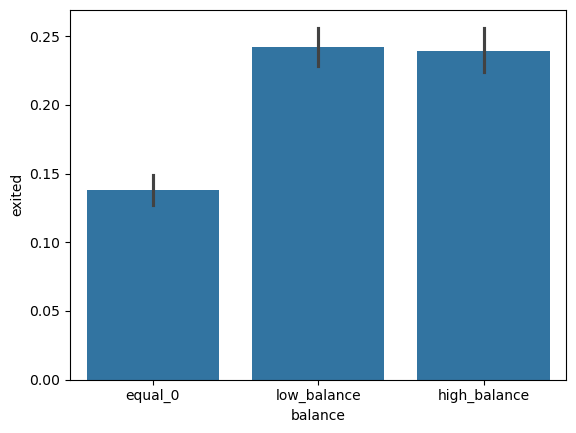

In [37]:
# let's try to find where come from this diference
# we can remember that we have a high number of balance = 0 
# it could be interessant to divid the balance and use balance = 0 as one of them to see if it represent a special caractere
# because this one represent a high number of values

nber_balance0 = df_consistent_variable[df_consistent_variable["balance"]==0]["balance"].count()

# let's say that under 125k balance is low and above, balance is high

def cat_balance(row):
    if row == 0:
        return 'equal_0'
    elif row >0 and row < 125000:
        return 'low_balance'
    else :
        return 'high_balance'

df_consistent_variable["balance"] = df_consistent_variable["balance"].apply(cat_balance)

# let's check the diference in a bar plot
sns.barplot(data=df_consistent_variable, x='balance', y='exited')
plt.show()

In [38]:
# we can effectivly see a diference in the exited proportion between equal 0 and both others 
# balance thanks to this barplot
# but it seems that the diference in proportion between low and high balance is quite low

# let's check with a z-test if we have a significant diference 

churn_lowbalance = df_consistent_variable[(df_consistent_variable["balance"]=="low_balance")&(df_consistent_variable["exited"]==1)]["balance"].count()
total_lowbalance = df_consistent_variable[df_consistent_variable["balance"]=="low_balance"]["balance"].count()

churn_highbalance = df_consistent_variable[(df_consistent_variable["balance"]=="high_balance")&(df_consistent_variable["exited"]==1)]["balance"].count()
total_highbalance = df_consistent_variable[df_consistent_variable["balance"]=="high_balance"]["balance"].count()

# H0 : we don't have a significantly diference between both variables
# H1 : we have a significantly diference between both variables

stats, p_value = proportions_ztest([churn_lowbalance, churn_highbalance], [total_lowbalance, total_highbalance])
# p_value = 0.7848770333834952 > 0.05
# H0 is accepted, we don't have a significative diference between both variables
# In this case, we can group low_balance and high_balance together and leave alone equal_0 to see if it's a determinent fact

df_consistent_variable["balance"] = np.where(df_consistent_variable["balance"]=="equal_0", 0, 1)
# let's categorise this variable as ordinal

In [39]:
# let's check now if the proportion of customers who exit being equal_0 are
# significantly smaller than bigger_0

churn_equal0 = df_consistent_variable[(df_consistent_variable["balance"]==0)&(df_consistent_variable["exited"]==1)]["balance"].count()
total_equal0 = df_consistent_variable[df_consistent_variable["balance"]==0]["balance"].count()

churn_bigger0 = df_consistent_variable[(df_consistent_variable["balance"]==1)&(df_consistent_variable["exited"]==1)]["balance"].count()
total_bigger0 = df_consistent_variable[df_consistent_variable["balance"]==1]["balance"].count()

# H0 : we don't have a significantly diference between both variables
# H1 : equal_0 is significantly smaller than bigger_0

stats, p_value = proportions_ztest([churn_equal0, churn_bigger0], [total_equal0, total_bigger0], alternative='smaller')
# p_value1.0015139401891095e-34

# We can also conclude something weird : The compararison in proportion of customers who exit
# Usually, more a customers have low balance more he have luck to leave because we can consider that this one is not active customer
# But on this case, that's the opposite !

## Number of product

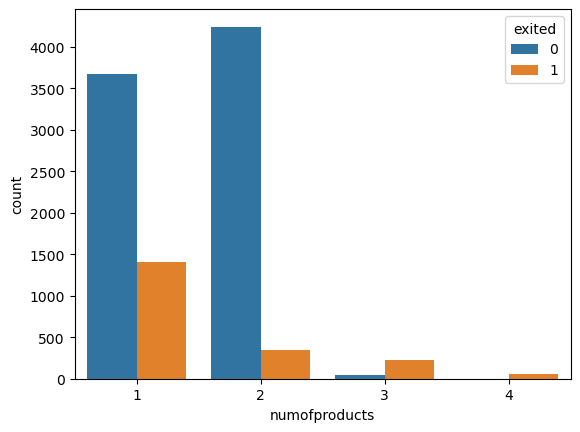

In [40]:

# what is the distribution of numofproducts ?

nber_product = df_consistent_variable["numofproducts"].value_counts()

# |numofproducts|count|
# +-------------+-----+
# |            1| 5084|
# |            3|  266|
# |            4|   60|
# |            2| 4590|

# we can see here that numofproducts == 3 and numofproducts == 4 is quite low to compare with 1 & 2
# so it can not help the model to understand behavior connected to that, above all for a linear model
# but let's check first if we can see a diference in proportion of exited for each numofproducts

sns.countplot(data=df_consistent_variable, x='numofproducts', hue='exited')
plt.show()

In [41]:
# Seen that numofproducts == 3 and numofproducts == 4 is quite low and seen that they 
# look have the same proportion of exited, we will try to see if we have a significantly 
# diference between both variables

churn_numofproducts3 = df_consistent_variable[(df_consistent_variable["numofproducts"]==3)&(df_consistent_variable["exited"]==1)]["numofproducts"].count()
total_numofproducts3 = df_consistent_variable[df_consistent_variable["numofproducts"]==3]["numofproducts"].count()

churn_numofproducts4 = df_consistent_variable[(df_consistent_variable["numofproducts"]==4)&(df_consistent_variable["exited"]==1)]["numofproducts"].count()
total_numofproducts4 = df_consistent_variable[df_consistent_variable["numofproducts"]==4]["numofproducts"].count()

# H0 : we doesn't have a significantly diference between both variables
# H1 : we have a significantly diference between both variables

stats, p_value = proportions_ztest([churn_numofproducts3, churn_numofproducts4], [total_numofproducts3, total_numofproducts4])
# p_value = 0.0005095033151678018 < 0.05
# H0 is rejected : we have a significantly diference between both variables
# stats = -3.4757097892668147
# So proportion of churn in numofproducts == 3 >  proportion churn numofproducts == 4

# Seen that we will use a model wich can handdle the imbalance, it will not be a problem to have
# a low count of values in numofproducts == 3 or numofproducts == 4

# let's try now to confirm this relationship between numofproducts and exited with a chi-test

# H0 : we don't have a significantly diference between both variables
# H1 : we have a significantly diference between both variables

tableau_contingence = pd.crosstab(df_consistent_variable['numofproducts'], df_consistent_variable['exited'])
chi2_stat, p_value, dof, expected_freq = chi2_contingency(tableau_contingence)

# p_value = 0.0 < 0.05 
# H0 is rejected, we have a significantly diference between both variables

stats = chi2_stat
n = df_consistent_variable.shape[0]
k1 = df_consistent_variable['numofproducts'].nunique()
k2 = df_consistent_variable['exited'].nunique() 

cramers_v = math.sqrt(stats / n / min(k1 - 1, k2 - 1))
# cramers_v = 0.38776660009689345 > 0.3
# cramers_v allow us to say that we have a high relation between exited and numofproducts


## Credit Card

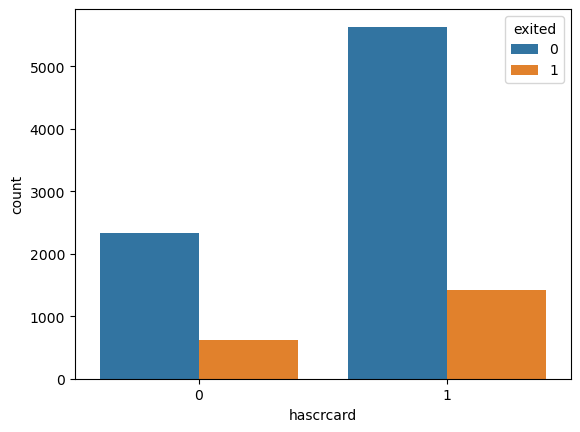

In [42]:
val_count_hascrcard = df_consistent_variable["hascrcard"].value_counts()

# +---------+-----+
# |hascrcard|count|
# +---------+-----+
# |        1| 7055|
# |        0| 2945|
# +---------+-----+

# we can see that we have more than 2 times customers who has a credit card than no credit card
# let's check how look's the distribution of hascrcard depending on exited

sns.countplot(data=df_consistent_variable, x='hascrcard', hue='exited')
plt.show()

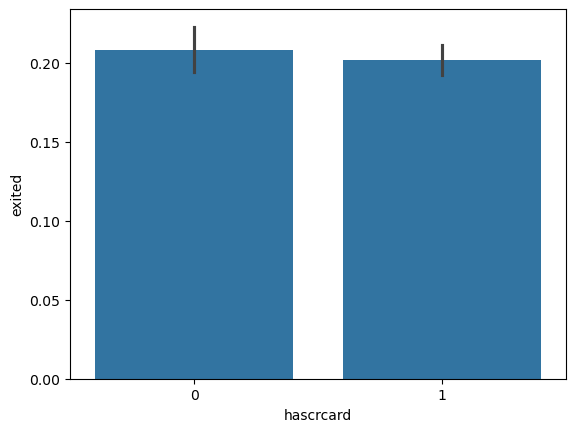

In [43]:
# Thanks to this countplot, we cannot clearly see a diference in proportion of 
# exited

# it will be may be more clear with a barplot to see if we have a diference 

sns.barplot(data=df_consistent_variable, x='hascrcard', y='exited')
plt.show()

In [44]:
# Thanks to this barplot we can effectivly see here say that we might not have a 
# significantly diference in proportion of exited for customers who has card or not
# let's confrirm that with a z-test proportion

churn_hascrcard1 = df_consistent_variable[(df_consistent_variable["hascrcard"]==1)&(df_consistent_variable["exited"]==1)]["hascrcard"].count()
total_hascrcard1 = df_consistent_variable[df_consistent_variable["hascrcard"]==1]["hascrcard"].count()

churn_hascrcard0 = df_consistent_variable[(df_consistent_variable["hascrcard"]==0)&(df_consistent_variable["exited"]==1)]["hascrcard"].count()
total_hascrcard0 = df_consistent_variable[df_consistent_variable["hascrcard"]==0]["hascrcard"].count()

# H0 : we doesn't have a significant diference in proportion of exited between has card or not
# H1 : we do have a significant diference in proportion of exited between has card or not

stats, p_value = proportions_ztest([churn_hascrcard1, churn_hascrcard0], [total_hascrcard1, total_hascrcard0])
# p_value = 0.4753653559706571 > 0.05
# H0 is accepted, we doesn't have a significant diference in proportion of exited between has card or not

# let's confirm that with a chi-test

# # H0 : we doesn't have a significant relationship between hascrcard and exited
# # H1 : we do have a significant relationship between hascrcard and exited

tableau_contingence = pd.crosstab(df_consistent_variable['hascrcard'], df_consistent_variable['exited'])
chi2_stat, p_value, dof, expected_freq = chi2_contingency(tableau_contingence)

# p_value = 0.0.49237236141554686 > 0.05

# p_value = 0.0.49237236141554686 > 0.05
# H0 is accepted, we doesn't have a significant relationship between hascrcard and exited
# So we can say that hascrcard alone, doesn't be usefull
# This variable will not help us to have a better model
# let's remove it from the dataframe

df_consistent_variable = df_consistent_variable.drop("hascrcard", axis=1)

## Active member

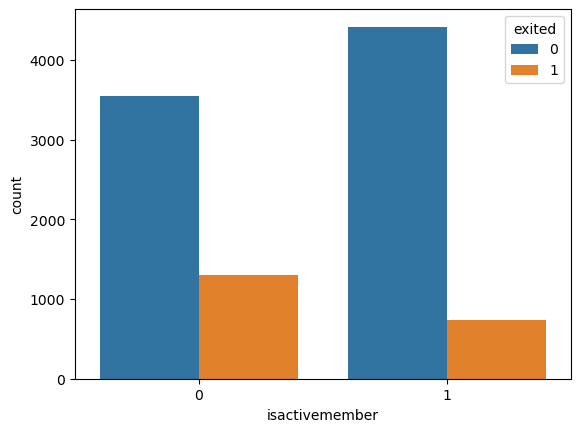

In [45]:
nber_value_active_member = df_consistent_variable["isactivemember"].value_counts()

# |isactivemember|count|
# +--------------+-----+
# |             1| 5151|
# |             0| 4849|


# let's check if we have a relationship between isactivemember and exited by doing the chi-test

# H0 : variables are independants
# H1 : we have a significative relation between both variable

tableau_contingence = pd.crosstab(df_consistent_variable['isactivemember'], df_consistent_variable['exited'])
chi2_stat, p_value, dof, expected_freq = chi2_contingency(tableau_contingence)

# chi_square_result = 8.785858269303703e-55 < 0.05
# H0 is rejected, we have a significative relation between both variable

# let's try to see that with a countplot :

sns.countplot(data=df_consistent_variable, x="isactivemember", hue="exited")
plt.show()

In [46]:
# thanks to this countplot we can confirm that relationship between both variables
# it's seems that the proportion of customers who are not active have more luck to leave 

# let's confirm that with a z-test

churn_active = df_consistent_variable[(df_consistent_variable["isactivemember"]==1)&(df_consistent_variable["exited"]==1)]["isactivemember"].count()
total_active = df_consistent_variable[df_consistent_variable["isactivemember"]==1]["isactivemember"].count()

churn_noactive = df_consistent_variable[(df_consistent_variable["isactivemember"]==0)&(df_consistent_variable["exited"]==1)]["isactivemember"].count()
total_noactive = df_consistent_variable[df_consistent_variable["isactivemember"]==0]["isactivemember"].count()

# H0 : we don't have a significant diference
# H1 : The proportion of churned in on active=0 is bigger than on active=1

stats, p_value = proportions_ztest([churn_noactive, churn_active], [total_noactive, total_active], alternative='larger')
# p_value = 2.9769262701820924e-55 < 0.05
# H0 is rejected, the proportion of churned in on active=0 is bigger than on active=1

proportions_active = round(churn_active / total_active, 2)
proportions_noactive = round(churn_noactive / total_noactive, 2)
# proportions_active = 0.14, proportions_noactive = 0.27
# The proportion of churn in no active customers is almost 2 time more bigger than churn for the actives customers



## Estimated Salary

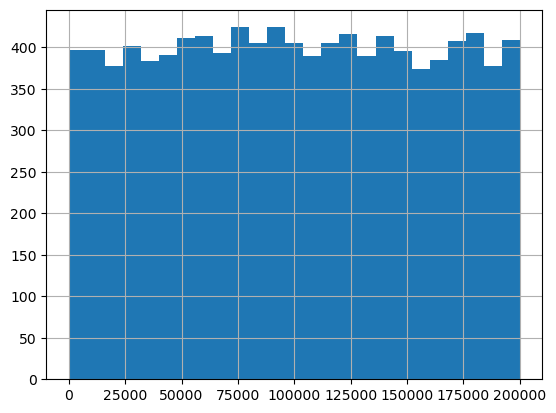

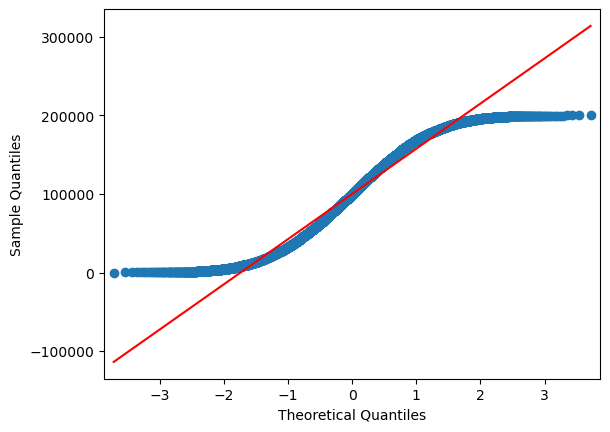

In [47]:
# let's check is estimatedsalary folow a normal distribution 

estimatedsalarys = df_consistent_variable["estimatedsalary"]

plt.hist(estimatedsalarys, bins=25)
plt.grid(True, linestyle='-')
plt.show()

estimatedsalarys_qqplot = np.array(estimatedsalarys)

sm.qqplot(estimatedsalarys_qqplot, line='s')
plt.show()


/Library/AppStore/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


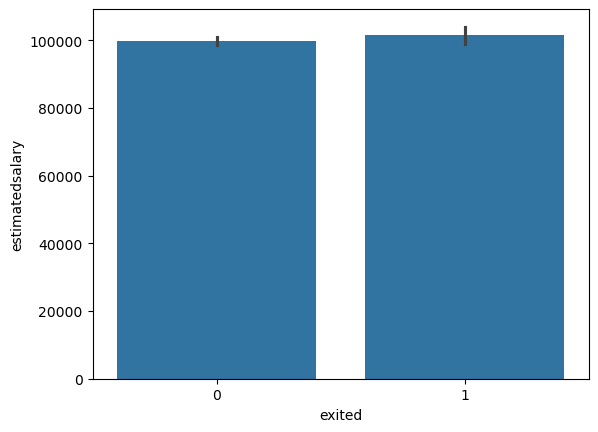

In [48]:


# Thanks to the histogram, we can say that this variable is relatively uniform
# Thanks to to qqplot, we can say that this variable doesn't folow a normal distribution
# We can say that she have heavy tails (left and right)

# let's confirm that our variable doesn't folow a normal distribution with a shapiro test

# H0 : estimatedsalarys folow a normal distribution
# H1 : estimatedsalarys doesn't folow a normal distribution

stat, p_val = st.shapiro(estimatedsalarys)
# p_val = 3.056073071154199e-47 < 0.05
# H0 is rejected, estimatedsalarys doesn't folow a normal distribution


# Do we have a relationship between estimatedsalary and exited ? 

# Seen that we are folowing the CLT hypothesis, let's see that with a t-test 
# let's put equal_var=False because our variable doesn't folow a normal distribution

estimatedsalarys_exited0 = df_consistent_variable[df_consistent_variable["exited"]==0]["estimatedsalary"]
estimatedsalarys_exited1 = df_consistent_variable[df_consistent_variable["exited"]==1]["estimatedsalary"]

# H0 : we doesn't have a significal diference between both
# H1 : we do have a significal difenrence between the both

stats, p_value = st.ttest_ind(estimatedsalarys_exited0, estimatedsalarys_exited1, equal_var=False)
# p_value = 0.22892461305145795 > 0.05
# H0 is accepted, we doesn't have a significal diference between both

# let's confirm that with a barplot

sns.barplot(data=df_consistent_variable, x='exited', y='estimatedsalary')
plt.show()

In [49]:
# we can effectivly see here that there mean are almost equal

df_consistent_variable.groupby(["exited"]).agg({"estimatedsalary": "mean"})

# +------+--------------------+
# |exited|avg(estimatedsalary)|
# +------+--------------------+
# |     1|   101465.6775306824|
# |     0|   99738.39177194514|
# +------+--------------------+

# let's see how it could be by grouping the estimated salary :
df_consistent_variable["estimatedsalary"].describe()
# min = 11.58
# max = 199992.48
# mean = 100090

# let's split the estimed salary by the folowing : 
# low estimated < 50 000 => 0
# medium >= 50 000 and < 150 000 => 1
# high >= 150 000 => 2
# we use numeric values to name the column because estimated salary can represent a ordinal categoric value for our model

def cat_estimatedsalary(row):
    if row <50000:
        return 0
    elif row >=50000 and row <150000:
        return 1
    else :
        return 2
        
df_consistent_variable["estimatedsalary"] = df_consistent_variable["estimatedsalary"].apply(cat_estimatedsalary)

# let's check now if we can see a diference with a countplot

pct = df_consistent_variable.groupby(["estimatedsalary"]).agg({"exited":"mean"})
# +---------------+-------------------+
# |estimatedsalary|        avg(exited)|
# +---------------+-------------------+
# |              1| 0.2005106048703849|
# |              2|0.21466395112016293|
# |              0| 0.1993477374643294|
# +---------------+-------------------+

# # it seems that even with a categorisation we doesn't have any diference on the churn proportion
# # We can conclude thanks to this analysis that we doesn't have a relationship between estimated salary and exited

# so let's drop estimated salary from the dataframe
df_consistent_variable = df_consistent_variable.drop("estimatedsalary", axis=1)

# PREDICTION

## Preparation

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import classification_report

In [51]:
# We finished our analysis 
# Let's now encode our nominal categorical variables 

df_final = df_consistent_variable
label_encoder = LabelEncoder()
df_final["geography"] = label_encoder.fit_transform(df_final["geography"])
df_final["gender"] = label_encoder.fit_transform(df_final["gender"])
df_final["age"] = label_encoder.fit_transform(df_final["age"])
df_final

,customerid,creditscore,geography,gender,age,balance,numofproducts,isactivemember,exited
0,15634602,0,0,0,0,0,1,1,1
1,15647311,0,0,0,0,1,1,1,0
2,15619304,1,0,0,0,1,3,0,1
3,15701354,0,0,0,0,0,2,0,0
4,15737888,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...
9995,15606229,0,0,1,0,0,2,0,0
9996,15569892,1,0,1,0,1,1,1,0
9997,15584532,0,0,0,0,0,1,1,1
9998,15682355,0,1,1,0,1,2,0,1


In [52]:
# let's split our dataframe

X = df_final.drop(columns=["exited"])
y = df_final["exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [53]:
# let's MinMAxScaler for the normalisation because our numerical even if there are now categorical,
# they don't folow a normal distribution

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Model 

### XBG

In [54]:
# let's to predict the the churn with models which can handle the imbalance :
# we will use "scale_pos_weight=4" the folowing models to give importance to imbalance

In [55]:
# Try XBG  
# let's put scale_pos_weight=4 to accord importance to the imbalance 

xbg = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.1, 
                    scale_pos_weight=4, random_state=0, verbosity=1)

xbg.fit(X_train_scaled, y_train)

xbg_pred = xbg.predict(X_test_scaled)

# accuracy = accuracy_score(y_test, xbg_pred)
# print("Accuracy :", accuracy)
# recall = recall_score(y_test, xbg_pred) 
# print("Recall :", recall)
# f1 = f1_score(y_test, xbg_pred)
# print("F1-score :", f1)
precision = precision_score(y_test, xbg_pred)
print("Precision :", precision)

# print()
# print(classification_report(y_test, xbg_pred))

# Accuracy : 0.7553333333333333
# Recall : 0.6360708534621579
# F1-score : 0.5183727034120735
# Precision : 0.4374307862679956

Precision : 0.4374307862679956


In [56]:
# we can clearly see that that the precision for class 1 is quit low
# let's try to change the threshold :

In [57]:
xbg_pred_proba = xbg.predict_proba(X_test_scaled)[:,1] 
threshold = 0.6
xbg_pred_adjusted = (xbg_pred_proba > threshold).astype(int)

accuracy= accuracy_score(y_test, xbg_pred_adjusted)
recall = recall_score(y_test, xbg_pred_adjusted)
f1 = f1_score(y_test, xbg_pred_adjusted)

# print(classification_report(y_test, xbg_pred_adjusted))

# print("Accuracy :", accuracy)
# print("Recall :", recall)
# print("F1-score :", f1)

# Accuracy : 0.782
# Recall : 0.5603864734299517
# F1-score : 0.5155555555555555

In [58]:
# It doesn't really affect it 
# let's see what append if we use imbalance management and change scale_pos_weight as well

smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [59]:
xbg = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, 
                    scale_pos_weight=1, subsample=1, random_state=0, verbosity=1)

xbg.fit(X_train_smote, y_train_smote)

xbg_pred = xbg.predict(X_test_scaled)

# accuracy = accuracy_score(y_test, xbg_pred)
# print("Accuracy :", accuracy)
# recall = recall_score(y_test, xbg_pred) 
# print("Recall :", recall)
# f1 = f1_score(y_test, xbg_pred)
# print("F1-score :", f1)

# print()
# print(classification_report(y_test, xbg_pred))

# Accuracy : 0.7683333333333333
# Recall : 0.7101449275362319
# F1-score : 0.559289790741915

In [60]:
# it doesn't really import our f1-score
# let's check with hyperparameters

In [61]:
xgbbis = XGBClassifier(scale_pos_weight=4, random_state=0, verbosity=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample' : [1.0, 2.0]}


# grid_search_xgbbis = GridSearchCV(estimator=xgbbis, param_grid=param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)

# grid_search_xgbbis.fit(X_train_scaled, y_train)

# pred_grid_search_xgbbis = grid_search_xgbbis.predict(X_test_scaled)

# print("Best params :", grid_search_xgbbis.best_params_)
# print("Best F1-score :", grid_search_xgbbis.best_score_)

# Best params : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
# Best F1-score : 0.5575965287478694

# It doesn't improve our f1-score

### Adaboost

In [62]:
# Try adaboosting
# For this one, we will use "class_weight="balanced"" to give importance to imbalance

base_model = DecisionTreeClassifier(max_depth=6, class_weight="balanced") 
adaboost = AdaBoostClassifier(estimator=base_model, n_estimators=50, random_state=0)
adaboost.fit(X_train_scaled, y_train)
adaboost_pred = adaboost.predict(X_test_scaled)

# accuracy = accuracy_score(y_test, adaboost_pred)
# print("Accuracy :", accuracy)
# recall = recall_score(y_test, adaboost_pred) 
# print("Recall :", recall)
# f1 = f1_score(y_test, adaboost_pred)
# print("F1-score :", f1)

# Accuracy : 0.7723333333333333
# Recall : 0.6618357487922706
# F1-score : 0.5461794019933555

In [63]:
# hyper parameters adaboost

base_model = DecisionTreeClassifier(max_depth=6, class_weight="balanced")

param_grid_cat = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'estimator__max_depth': [4, 5, 6], 
}

# adaboost = AdaBoostClassifier(estimator=base_model, random_state=0)

# grid_search = GridSearchCV(adaboost, param_grid_cat, cv=5, scoring='f1', n_jobs=-1)
# grid_search.fit(X_train_scaled, y_train)

# print("Best params :", grid_search.best_params_)
# print("Best f1-score :", grid_search.best_score_)

# Best params : {'estimator__max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 200}
# Best f1-score : 0.5659884564919017

In [64]:
# It seems that the best cannot really help us to improve the F1-Score
# Let's try to use parameters with random forest

In [65]:
# With those model above, we can see that the accuracy and the recall are good
# But f1-score is quite low wich mean that we have a imbalance between accuracy and recall
# let's check with RandomForest model what we can have in terms of precision
# which suppose to less handle the imbalance

## Conclude

In [66]:
# It seems that we cannot significantly improve our f1-score
# Finaly we can conclude that our model work weel but we still have a gap 
# between recall and accuracy and we doesn't improved our f1-score thanks to the hyperparameters

In [67]:
# Which model we will keep ?
# Seen that our goal is to predict the churn, our company for sure, prefere to have
# a False churn than the opposite. Because that will be a cost for us we if we cannot find the True churn.
# And even when we have a imbalance case and f1-score can help us to know if our model can handle that, 
# The most important thing is do does't miss the True churn
# So on this case, that's better to favor a high accuracy/recall than f1-score

# Based on that, let's use xgb classifier as our model 

In [68]:
# Let's check if this model is overfited 

#xbg.predict(X_train_scaled)

# accuracy = accuracy_score(y_test, xbg_pred)
# print("Accuracy :", accuracy)
# recall = recall_score(y_test, xbg_pred) 
# print("Recall :", recall)
# f1 = f1_score(y_test, xbg_pred)
# print("F1-score :", f1)

# Accuracy : 0.7623333333333333
# Recall : 0.7439613526570048
# F1-score : 0.5644471594379963

# it seems that not 

## Model without management

In [69]:

# let's try to see the precision without any management (except for removing row_number, surname, customerid) :

url2 = r"/Users/thomas/Documents/Ironhack_final_project/Churn_Modelling.csv"
df2 = pd.read_csv(url2)
df2 = df2.drop(columns=["RowNumber", "Surname"])
label_encoder = LabelEncoder()
df2["Geography"] = label_encoder.fit_transform(df2["Geography"])
df2["Gender"] = label_encoder.fit_transform(df2["Gender"])

X = df2.drop(columns=["Exited"])
y = df2["Exited"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

xgb3 = XGBClassifier(scale_pos_weight=5, random_state=0, verbosity=1)
xgb3.fit(X_train_scaled2, y_train2)
xgb3_pred = xgb3.predict(X_test_scaled2)

accuracy = accuracy_score(y_test2, xgb3_pred)
recall = recall_score(y_test2, xgb3_pred)
f1 = f1_score(y_test2, xgb3_pred)

# print(accuracy, recall, f1)

# accuracy, recall, f1
# (0.8136666666666666 0.6570048309178744 0.5934545454545455)

# Thanks to that we can see that our management on data doesn't really affecte our predictive model
# Let's say that we keep our model with management because we have less features which is less complexe so better for our model


## Prediction for all the dataframe

In [70]:
test_first = df_final
X_test_first = test_first.drop(columns=["exited"])
y_test_first = test_first["exited"]

X_test_first_scaled = scaler.fit_transform(X_test_first)

test_first["pred"] = xbg.predict(X_test_first_scaled)

def comparison(row):
    if row["exited"] == 1 and row["pred"] == 1:
        return True
    elif row["exited"] == 0 and row["pred"] == 0:
        return True
    else :
        return False
test_first["comparison"] = test_first.apply(comparison, axis=1)
test_first

,customerid,creditscore,geography,gender,age,balance,numofproducts,isactivemember,exited,pred,comparison
0,15634602,0,0,0,0,0,1,1,1,0,False
1,15647311,0,0,0,0,1,1,1,0,0,True
2,15619304,1,0,0,0,1,3,0,1,1,True
3,15701354,0,0,0,0,0,2,0,0,0,True
4,15737888,0,0,0,0,1,1,1,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,0,0,1,0,0,2,0,0,0,True
9996,15569892,1,0,1,0,1,1,1,0,0,True
9997,15584532,0,0,0,0,0,1,1,1,1,True
9998,15682355,0,1,1,0,1,2,0,1,0,False


In [71]:
nber_false = test_first[test_first["comparison"] ==False]["comparison"].count()
nber_false_exited = test_first[(test_first["comparison"] ==False)&(test_first["exited"]==1)]["comparison"].count()
nber_false_no_exited = test_first[(test_first["comparison"] ==False)&(test_first["exited"]==0)]["comparison"].count()

# nber_false = 2052
# so 20.52% of our prediction were false

# nber_false_exited = 560
# 560 of the 2052 rows predicted churned instead of no churned 
# we missed 5.56% of the churned person

# nber_false_no_exited = 1492
# 1492 of the 2052 rows predicted no churned instead of churned

# as i said earlier that's better to predict more churned and to focus on them to avoid the churn

nber_false, nber_false_exited, nber_false_no_exited

(np.int64(2052), np.int64(560), np.int64(1492))

# SCORING

## Test 1

In [72]:
## Let's say that because our model is not enought close to predict if a user will churn or not, we can try to create something with more contraste
# Let's create a scoring base on 100% which 100 mean that the customers will leave
# we will use only variables that have a relationship with the target variable

# How the scoring will be calculated? 
# We will use the numerical aspect of all variables to calculate it 
# Each values of each variable will be sorted starting by 0.
# How they will be sorted ? 
# The values which have the less proportion of exited (by grouping the variables and get the mean of exited) will be = 0
# And it will folowing increasingly

# we will have to define some coeficient for each 
# we will define the coeficient by the folowing :
# we will compare the diference in proportion between the max and min values of exited mean for each variable
# if we have a big diference, we will use coeficient to allow those values to influence the scoring


# So more the score is high more the customers have the luck to leave



In [73]:
test2 = df_final
df_test1 = df_consistent_variable

## Test 2

In [74]:
# let's try to replace the values by their proportion of churn without any coef 

df_test2 = df_consistent_variable
label_encoder = LabelEncoder()
df_test2["geography"] = label_encoder.fit_transform(df_test2["geography"])
df_test2["gender"] = label_encoder.fit_transform(df_test2["gender"])
df_test2["age"] = label_encoder.fit_transform(df_test2["age"])
df_test2

,customerid,creditscore,geography,gender,age,balance,numofproducts,isactivemember,exited,pred,comparison
0,15634602,0,0,0,0,0,1,1,1,0,False
1,15647311,0,0,0,0,1,1,1,0,0,True
2,15619304,1,0,0,0,1,3,0,1,1,True
3,15701354,0,0,0,0,0,2,0,0,0,True
4,15737888,0,0,0,0,1,1,1,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,0,0,1,0,0,2,0,0,0,True
9996,15569892,1,0,1,0,1,1,1,0,0,True
9997,15584532,0,0,0,0,0,1,1,1,1,True
9998,15682355,0,1,1,0,1,2,0,1,0,False


In [75]:
## CREDITSCORE ##
# credits = df_test2.groupby(["creditscore"])["exited"].mean().round(2)
# creditscore
# 0    0.20
# 1    0.23

df_test2["creditscore"] = df_test2["creditscore"].map({0.00:0.2,1:0.23})

dif_credit = 0.23 / 0.2
# dif_credit = 1.15

## GEOGRAPHY ##
# geography = df_test2.groupby(["geography"])["exited"].mean().round(2)
# 0    0.16
# 1    0.32

df_test2["geography"] = df_test2["geography"].map({0:0.16,1:0.32})

dif_geo = 0.32 / 0.16
# dif_geo = 2.0

## GENDER ## 
# gender = df_test2.groupby(["gender"])["exited"].mean().round(2)
# 0    0.16
# 1    0.25

df_test2["gender"] = df_test2["gender"].map({0:0.16,1:0.25})

dif_gender = 0.25 / 0.16
# dif_gender = 1.56

## AGE ## 
# ages = df_test2.groupby(["age"])["exited"].mean().round(2)
# 0    0.08
# 1    0.18
# 2    0.45

df_test2["age"] = df_test2["age"].map({0:0.08, 1:0.18, 2:0.45})

dif_age = 0.45 / 0.08
# dif_age = 2.5

## BALANCE ## 
# balance = df_test2.groupby(["balance"])["exited"].mean().round(2)
# 0    0.14
# 1    0.24

df_test2["balance"] = df_test2["balance"].map({0:0.14, 1:0.24})

dif_balance = 0.24/ 0.14
# dif_balance = 1.71

## NUM OF PRODUCTS ##
# numofproduct = df_test2.groupby(["numofproducts"])["exited"].mean().round(2)
# 0    0.08
# 1    0.28
# 2    0.83
# 3    1.00

df_test2["numofproducts"] = df_test2["numofproducts"].map({0:0.08, 1:0.28, 2:0.83, 3:1})

dif_numprod = 1 / 0.08
# dif_numprod = 12.5

## ACTIVE MEMBER ##
# isactivemembers = df_test2.groupby(["isactivemember"])["exited"].mean().round(2)
# 0    0.14
# 1    0.27

df_test2["isactivemember"] = df_test2["isactivemember"].map({0:0.14, 1:0.27})

dif_active = 0.27/0.14
# dif_active = 1.93


In [76]:
df_test2["total2"] = df_test2["creditscore"] + df_test2["geography"] + df_test2["gender"] + df_test2["age"] + df_test2["balance"] + df_test2["numofproducts"] + df_test2["isactivemember"]
df_test2["total2"] = (df_test2["total2"] - df_test2["total2"].min())/(df_test2["total2"].max()-df_test2["total2"].min())

def group_data(row):
    if row <= 0.3:
        return '0-0.3'
    elif row > 0.3 and row <= 0.5:
        return '0.35 - 0.5'
    elif row > 0.5 and row <= 0.7:
        return '0.5 - 0.7'
    else :
        return '> 0.7'
df_test2["total2"] = df_test2["total2"].apply(group_data)

In [77]:
df_test2["total2"] = df_test2["total2"]
result2 = df_test2.groupby(["exited", "total2"])["exited"].count().rename('counting2')
result2 = result2.reset_index()

total_exited0 = result2[result2["exited"]==0]["counting2"].sum()
total_exited1 = result2[result2["exited"]==1]["counting2"].sum()

def percentage(row):
    if row["exited"] == 0 :
        return round(row["counting2"] / total_exited0, 2)*100
    elif row["exited"] == 1 :
        return round(row["counting2"] / total_exited1, 2)*100
result2["percentage"] = result2.apply(percentage, axis=1)
result2

,exited,total2,counting2,percentage
0,0,0-0.3,3034,38.0
1,0,0.35 - 0.5,2872,36.0
2,0,0.5 - 0.7,1630,20.0
3,0,> 0.7,427,5.0
4,1,0-0.3,1263,62.0
5,1,0.35 - 0.5,314,15.0
6,1,0.5 - 0.7,336,16.0
7,1,> 0.7,124,6.0


In [78]:
# This test is not really satisfying
# We cannot really conclude something thanks to it

## Test 4

In [79]:
# let's check how can be the scoring without the previous management on data
# We will have for sure more contrast in the scoring

url2 = r"/Users/thomas/Documents/Ironhack_final_project/Churn_Modelling.csv"
df_test = pd.read_csv(url2)
df_test.columns = [col.lower() for col in df_test.columns]
df_test4 = df_test.drop(columns=["rownumber", "surname", "hascrcard", "creditscore", "estimatedsalary"])
df_test4

,customerid,geography,gender,age,tenure,balance,numofproducts,isactivemember,exited
0,15634602,France,Female,42,2,0.00,1,1,1
1,15647311,Spain,Female,41,1,83807.86,1,1,0
2,15619304,France,Female,42,8,159660.80,3,0,1
3,15701354,France,Female,39,1,0.00,2,0,0
4,15737888,Spain,Female,43,2,125510.82,1,1,0
...,...,...,...,...,...,...,...,...,...
9995,15606229,France,Male,39,5,0.00,2,0,0
9996,15569892,France,Male,35,10,57369.61,1,1,0
9997,15584532,France,Female,36,7,0.00,1,1,1
9998,15682355,Germany,Male,42,3,75075.31,2,0,1


In [80]:
# let's get the proportion of customers per geography

geo_prop = df_test4.groupby(["geography"])["exited"].mean().round(2).rename('mean_exited').reset_index()
geo_prop_dict = {row["geography"] : row["mean_exited"] for idx, row in geo_prop.iterrows()}
geo_prop_dict

def asprop(row):

    for geo, prop in geo_prop_dict.items():
        if row == geo:
            row = prop
            return row
            
df_test4["geography"] = df_test4["geography"].apply(asprop)

# gender #

gender_prop = df_test4.groupby(["gender"])["exited"].mean().round(2).rename('mean_exited2').reset_index()
gender_prop_dict = {row["gender"] : row["mean_exited2"] for idx, row in gender_prop.iterrows()}

def asprop(row):

    for gen, prop in gender_prop_dict.items():
        if row == gen:
            row = prop
            return row
            
df_test4["gender"] = df_test4["gender"].apply(asprop)


# age #

age_prop = df_test4.groupby(["age"])["exited"].mean().round(2).rename('mean_exited3').reset_index()
age_prop_dict = {row["age"] : row["mean_exited3"] for idx, row in age_prop.iterrows()}

def asprop(row):

    for age, prop in age_prop_dict.items():
        if row == age:
            row = prop
            return row
            
df_test4["age"] = df_test4["age"].apply(asprop)


# balance #

balance_prop = df_test4.groupby(["balance"])["exited"].mean().round(2).rename('mean_exited4').reset_index()
balance_prop_dict = {row["balance"] : row["mean_exited4"] for idx, row in balance_prop.iterrows()}

def asprop(row):

    for bal, prop in balance_prop_dict.items():
        if row == bal:
            row = prop
            return row
            
df_test4["balance"] = df_test4["balance"].apply(asprop)

# numofproducts #

prod_prop = df_test4.groupby(["numofproducts"])["exited"].mean().round(2).rename('mean_exited5').reset_index()
prod_prop_dict = {row["numofproducts"] : row["mean_exited5"] for idx, row in prod_prop.iterrows()}

def asprop(row):

    for prod, prop in prod_prop_dict.items():
        if row == prod:
            row = prop
            return row
            
df_test4["numofproducts"] = df_test4["numofproducts"].apply(asprop)

# isactivemember #

active_prop = df_test4.groupby(["isactivemember"])["exited"].mean().round(2).rename('mean_exited6').reset_index()
active_prop_dict = {row["isactivemember"] : row["mean_exited6"] for idx, row in active_prop.iterrows()}

def asprop(row):

    for act, prop in active_prop_dict.items():
        if row == act:
            row = prop
            return row
            
df_test4["isactivemember"] = df_test4["isactivemember"].apply(asprop)

tenure_prop = df_test4.groupby(["tenure"])["exited"].mean().round(2).rename('avg_mean').reset_index()

# same here for tenure, it seems that we do have a significant diference of proportion

tenure_prop_dict = {row["tenure"] : row["avg_mean"] for idx, row in tenure_prop.iterrows()}

def asprop(row):
    for ten, prop in tenure_prop_dict.items():
        if row==ten:
            row=prop
            return row
df_test4["tenure"] = df_test4["tenure"].apply(asprop)


df_test4["total4"] = df_test4["geography"]+df_test4["gender"]+df_test4["age"]+df_test4["balance"]+df_test4["numofproducts"]+df_test4["isactivemember"]+df_test4["tenure"]

df_test4["total4"] = (df_test4["total4"] - df_test4["total4"].min()) / (df_test4["total4"].max() - df_test4["total4"].min())

df_test4

,customerid,geography,gender,age,tenure,balance,numofproducts,isactivemember,exited,total4
0,15634602,0.16,0.25,0.24,0.19,0.14,0.28,0.14,1,0.229167
1,15647311,0.17,0.25,0.19,0.22,0.00,0.28,0.14,0,0.177083
2,15619304,0.16,0.25,0.24,0.19,1.00,0.83,0.27,1,0.763889
3,15701354,0.16,0.25,0.17,0.22,0.14,0.08,0.27,0,0.190972
4,15737888,0.17,0.25,0.30,0.19,0.00,0.28,0.14,0,0.204861
...,...,...,...,...,...,...,...,...,...,...
9995,15606229,0.16,0.16,0.17,0.21,0.14,0.08,0.27,0,0.156250
9996,15569892,0.16,0.16,0.12,0.21,0.00,0.28,0.14,0,0.114583
9997,15584532,0.16,0.25,0.12,0.17,0.14,0.28,0.14,1,0.180556
9998,15682355,0.32,0.16,0.24,0.21,1.00,0.08,0.27,1,0.534722


In [81]:
def group_data(row):
    if row <= 0.3:
        return '0-0.3'
    elif row > 0.3 and row <= 0.5:
        return '0.35 - 0.5'
    elif row > 0.5 and row <= 0.7:
        return '0.5 - 0.7'
    else :
        return '> 0.7'
df_test4["total4"] = df_test4["total4"].apply(group_data)


result4 = df_test4.groupby(["exited", "total4"])["exited"].count().rename('counting4')
result4 = result4.reset_index()

total_exited0 = result4[result4["exited"]==0]["counting4"].sum()
total_exited1 = result4[result4["exited"]==1]["counting4"].sum()

def percentage(row):
    if row["exited"] == 0 :
        return round(row["counting4"] / total_exited0, 2)*100
    elif row["exited"] == 1 :
        return round(row["counting4"] / total_exited1, 2)*100
result4["percentage"] = result4.apply(percentage, axis=1)

display(result4)

,exited,total4,counting4,percentage
0,0,0-0.3,7713,97.0
1,0,0.35 - 0.5,248,3.0
2,0,0.5 - 0.7,2,0.0
3,1,0-0.3,257,13.0
4,1,0.35 - 0.5,372,18.0
5,1,0.5 - 0.7,1065,52.0
6,1,> 0.7,343,17.0


In [82]:
# thanks to the test 4 we can know that every customer which get a a counting total above 0.5 is churned
# but we missing some customers wich are under 0.5
# They representing 69% of the churn 

In [83]:
df_test_use = df_test.drop(columns=["rownumber", "surname", "geography", "gender", "age", "balance", "numofproducts", "isactivemember"])
df_test_use

,customerid,creditscore,tenure,hascrcard,estimatedsalary,exited
0,15634602,619,2,1,101348.88,1
1,15647311,608,1,0,112542.58,0
2,15619304,502,8,1,113931.57,1
3,15701354,699,1,0,93826.63,0
4,15737888,850,2,1,79084.10,0
...,...,...,...,...,...,...
9995,15606229,771,5,1,96270.64,0
9996,15569892,516,10,1,101699.77,0
9997,15584532,709,7,0,42085.58,1
9998,15682355,772,3,1,92888.52,1


## Test 5 

In [84]:
# let's try try to improve the test 4 by adding all the variables

df_test5 = df_test4.drop(columns=["total4", "exited", "tenure"])
df_test5_1 = pd.merge(df_test5, df_test_use, on='customerid', how='inner')

# as we did earlier, let's replace the value from the new variables by their churn proportion

# creditscore # 
# let's first group by the creditscore by undred

df_test5_1["creditscore"] = (df_test5_1["creditscore"] // 100) * 100

r = df_test5_1["creditscore"].value_counts()

# creditscore
# 600    3818
# 700    2493
# 500    2402
# 800     655
# 400     613
# 300      19

sp = df_test5_1[df_test5_1["creditscore"] < 400]

# it seems that we missed that earlier ! 
# it's true that we only have 19 values which have creditscore == 300 but they all exited
df_test5_1 = df_test5_1.drop(columns=["tenure"])

In [85]:
credrit_prop = df_test5_1.groupby(["creditscore"])["exited"].mean().round(2).rename('avg_mean').reset_index()
credrit_prop_dict = {row["creditscore"] : row["avg_mean"] for idx, row in credrit_prop.iterrows()}

def asprop(row):
    for cre, prop in credrit_prop_dict.items():
        if row==cre:
            row=prop
            return row
df_test5_1["creditscore"] = df_test5_1["creditscore"].apply(asprop)

# tenure_prop = df_test5_1.groupby(["tenure"])["exited"].mean().round(2).rename('avg_mean').reset_index()

# # same here for tenure, it seems that we do have a significant diference of proportion

# tenure_prop_dict = {row["tenure"] : row["avg_mean"] for idx, row in tenure_prop.iterrows()}

# def asprop(row):
#     for ten, prop in tenure_prop_dict.items():
#         if row==ten:
#             row=prop
#             return row
# df_test5_1["tenure"] = df_test5_1["tenure"].apply(asprop)


card_prop = df_test5_1.groupby(["hascrcard"])["exited"].mean().round(2).rename('avg_mean').reset_index()
card_prop_dict = {row["hascrcard"] : row["avg_mean"] for idx, row in card_prop.iterrows()}

def asprop(row):
    for card, prop in card_prop_dict.items():
        if row==card:
            row=prop
            return row
df_test5_1["hascrcard"] = df_test5_1["hascrcard"].apply(asprop)

# We have to do modifiate the values of estimated values because we have to much diferent values 

def clas_salary(row):
    if row <= 50000:
        return '<= 50k'
    elif row > 50000 and row <=100000:
        return '50k-100k'
    elif row > 100000 and row <=150000:
        return '100k-150k'
    elif row >150000 :
        return '> 150k'

df_test5_1["estimatedsalary"] = df_test5_1["estimatedsalary"].apply(clas_salary)

salary_prop = df_test5_1.groupby(["estimatedsalary"])["exited"].mean().round(2).rename('avg_mean').reset_index()
salary_prop_dict = {row["estimatedsalary"] : row["avg_mean"] for idx, row in salary_prop.iterrows()}
def asprop_sal(row):
    for sal, prop in salary_prop_dict.items():
        if row==sal:
            row=prop
            return row
df_test5_1["estimatedsalary"] = df_test5_1["estimatedsalary"].apply(asprop_sal)
df_test5_1

,customerid,geography,gender,age,balance,numofproducts,isactivemember,creditscore,hascrcard,estimatedsalary,exited
0,15634602,0.16,0.25,0.24,0.14,0.28,0.14,0.20,0.20,0.2,1
1,15647311,0.17,0.25,0.19,0.00,0.28,0.14,0.20,0.21,0.2,0
2,15619304,0.16,0.25,0.24,1.00,0.83,0.27,0.21,0.20,0.2,1
3,15701354,0.16,0.25,0.17,0.14,0.08,0.27,0.20,0.21,0.2,0
4,15737888,0.17,0.25,0.30,0.00,0.28,0.14,0.20,0.20,0.2,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,0.16,0.16,0.17,0.14,0.08,0.27,0.20,0.20,0.2,0
9996,15569892,0.16,0.16,0.12,0.00,0.28,0.14,0.21,0.20,0.2,0
9997,15584532,0.16,0.25,0.12,0.14,0.28,0.14,0.20,0.21,0.2,1
9998,15682355,0.32,0.16,0.24,1.00,0.08,0.27,0.20,0.20,0.2,1


In [86]:
df_test5_1["total5"] = df_test5_1["geography"] + df_test5_1["gender"] + df_test5_1["age"] + df_test5_1["balance"] + df_test5_1["numofproducts"] + df_test5_1["isactivemember"] + df_test5_1["creditscore"] + df_test5_1["hascrcard"] + df_test5_1["estimatedsalary"]
df_test5_1["total5"] = (df_test5_1["total5"] - df_test5_1["total5"].min()) / (df_test5_1["total5"].max() - df_test5_1["total5"].min())

df_test5_1["total5"] = df_test5_1["total5"].round(2)

def group_data(row):
    if row <= 0.3:
        return '0-0.3'
    elif row > 0.3 and row <= 0.5:
        return '0.35 - 0.5'
    elif row > 0.5 and row <= 0.7:
        return '0.5 - 0.7'
    else :
        return '> 0.7'
df_test5_1["total5"] = df_test5_1["total5"].apply(group_data)


result5 = df_test5_1.groupby(["exited", "total5"])["exited"].count().rename('counting5')
result5 = result5.reset_index()

total_exited0 = result5[result5["exited"]==0]["counting5"].sum()
total_exited1 = result5[result5["exited"]==1]["counting5"].sum()

def percentage(row):
    if row["exited"] == 0 :
        return round(row["counting5"] / total_exited0, 2)*100
    elif row["exited"] == 1 :
        return round(row["counting5"] / total_exited1, 2)*100
result5["percentage"] = result5.apply(percentage, axis=1)

display(result5, result4)

,exited,total5,counting5,percentage
0,0,0-0.3,7904,99.0
1,0,0.35 - 0.5,59,1.0
2,1,0-0.3,358,18.0
3,1,0.35 - 0.5,809,40.0
4,1,0.5 - 0.7,781,38.0
5,1,> 0.7,89,4.0


,exited,total4,counting4,percentage
0,0,0-0.3,7713,97.0
1,0,0.35 - 0.5,248,3.0
2,0,0.5 - 0.7,2,0.0
3,1,0-0.3,257,13.0
4,1,0.35 - 0.5,372,18.0
5,1,0.5 - 0.7,1065,52.0
6,1,> 0.7,343,17.0


## Conclude

In [87]:
# We cannot be satisfied of the test 5 because we have less percentage of persone >0.7 and more person < 0.3 with exited=1
# It seems that adding more columns doen't help us to reduce the number of client who's exited under 0.5


# COMBINING MODEL AND SCORE

In [88]:
# The purpose of the combining is to get the best exited prediction by combining our xgb prediction model and the scoring

# We already know that with our test4, every customer who get more than 0.5 is churned
# So we will use this and

## Combining 

In [89]:
# Define that above 0.5 of the total's test4 every customer churned

def scoring(row):
    if row == '0.5 - 0.7' or row == '> 0.7':
        return 'churned'
    else :
        return row
df_test4["total4"] = df_test4["total4"].apply(scoring)


In [90]:
# take the xbg prediction appliqued to our database
test_first_use = test_first.drop(columns=["creditscore", "geography", "gender", "age", "balance", "numofproducts", "isactivemember", "exited", "comparison", "customerid", "total2"])

df_choosed_test = df_test4.drop(columns=["geography", "age", "gender", "balance", "tenure", "numofproducts", "isactivemember"])

# merge the df from prediction model and the df from test4
df_result =  pd.merge(df_choosed_test, test_first_use, left_index=True, right_index=True, how="inner")

### Test Combining 1

In [91]:
# Let's try our first combinaison
# If test4 = churned and pred = 1 then return 1 and see if this result is true (compared with the reality) 

def final_pred(row):

    if (row["total4"] == 'churned' or row["pred"] == 1) or (row["total4"] == 'churned' and row["pred"] == 1):
        return 1
    else :
        return row["pred"]

df_result["pred_combined"] = df_result.apply(final_pred, axis=1)

def compare(row):
    if row["exited"] == row["pred_combined"]:
        return True
    else:
        return False
df_result["comparison"] = df_result.apply(compare, axis=1)


In [92]:
group = df_result.groupby(["exited","total4", "pred", "comparison"])["customerid"].count().rename('counting').reset_index()
group

,exited,total4,pred,comparison,counting
0,0,0-0.3,0,True,6417
1,0,0-0.3,1,False,1296
2,0,0.35 - 0.5,0,True,53
3,0,0.35 - 0.5,1,False,195
4,0,churned,0,False,1
5,0,churned,1,False,1
6,1,0-0.3,0,False,108
7,1,0-0.3,1,True,149
8,1,0.35 - 0.5,0,False,152
9,1,0.35 - 0.5,1,True,220


In [93]:
# let's count how much False result do we have

false_r = df_result[df_result["comparison"]==False]["comparison"].count()
# false_r = 1753 < 2052 (with the model only)

# how many are false no churn ?
false_churn = df_result[(df_result["comparison"]==False)&(df_result["exited"]==1)]["comparison"].count()
# false_churn = 260

# So we are missing 260 person who churn, 2.6% < 5.58

false_no_churn = df_result[(df_result["comparison"]==False)&(df_result["exited"]==0)]["comparison"].count()
# False no churn = 1493

false_r, false_no_churn

(np.int64(1753), np.int64(1493))

In [94]:
# Here we can see that we still have a high number of false prediction but
# the number of real churn that we missed is quit low 
# We can also clearly see here that the scoring allowed us to find 304 real churn that our model missed

### Test Combining 2

In [95]:
def final_pred(row):

    if row["total4"] == 'churned' or row["pred"] == 1 and row["total4"] != '0-0.3':
        return 1
    elif row["total4"] == '0-0.3':
        return 0
    else :
        return row["pred"]

df_result["pred_combined"] = df_result.apply(final_pred, axis=1)

def compare(row):
    if row["exited"] == row["pred_combined"]:
        return True
    else:
        return False
df_result["comparison2"] = df_result.apply(compare, axis=1)


group2 = df_result.groupby(["exited","total4", "pred", "comparison2"])["customerid"].count().rename('counting').reset_index()
group2

,exited,total4,pred,comparison2,counting
0,0,0-0.3,0,True,6417
1,0,0-0.3,1,True,1296
2,0,0.35 - 0.5,0,True,53
3,0,0.35 - 0.5,1,False,195
4,0,churned,0,False,1
5,0,churned,1,False,1
6,1,0-0.3,0,False,108
7,1,0-0.3,1,False,149
8,1,0.35 - 0.5,0,False,152
9,1,0.35 - 0.5,1,True,220


In [96]:
# let's count how much False result do we have

false_r = df_result[df_result["comparison2"]==False]["comparison2"].count()
# false_r = 606 < 1753 (combining 1)

# how many are false no churn ?
false_no_churn = df_result[(df_result["comparison2"]==False)&(df_result["exited"]==1)]["comparison2"].count()
# false_no_churn = 409

# So we are missing 409 person who churn, 4% > 2.5
# So here we did improve the prediction, because we only false predict 6.3% of our customers
# But we now miss more churn customers
false_r, false_no_churn

(np.int64(606), np.int64(409))

### Test Combining 3 

In [97]:
def final_pred(row):
    if row["total4"] == '0-0.3':
        return 0
    elif row["total4"] == 'churned':
        return 1
    elif row["total4"] == '0.35 - 0.5':
         return 1   
    
    else :
        return row["pred"]

df_result["pred_combined"] = df_result.apply(final_pred, axis=1)

def compare(row):
    if row["exited"] == row["pred_combined"]:
        return True
    else:
        return False
df_result["comparison3"] = df_result.apply(compare, axis=1)


group3 = df_result.groupby(["exited","total4", "pred", "comparison3"])["customerid"].count().rename('counting').reset_index()

In [98]:
false_r = df_result[df_result["comparison3"]==False]["comparison3"].count()
# false_r = 507 < 606

# how many are false no churn ?
false_no_churn = df_result[(df_result["comparison3"]==False)&(df_result["exited"]==1)]["comparison3"].count()
# false_no_churn = 257

# so we only predict false for 5% 
# and miss 2.5% of the real churn

false_r, false_no_churn

(np.int64(507), np.int64(257))

### Test Combining 4

In [99]:
def final_pred(row):

    if row["total4"] == 'churned' or row["total4"] == '0.35 - 0.5':
        return 1        
    else :
        return row["pred"]

df_result["pred_combined"] = df_result.apply(final_pred, axis=1)

def compare(row):
    if row["exited"] == row["pred_combined"]:
        return True
    else:
        return False
df_result["comparison4"] = df_result.apply(compare, axis=1)


group4 = df_result.groupby(["exited","total4", "pred", "comparison4"])["customerid"].count().rename('counting').reset_index()
group4

,exited,total4,pred,comparison4,counting
0,0,0-0.3,0,True,6417
1,0,0-0.3,1,False,1296
2,0,0.35 - 0.5,0,False,53
3,0,0.35 - 0.5,1,False,195
4,0,churned,0,False,1
5,0,churned,1,False,1
6,1,0-0.3,0,False,108
7,1,0-0.3,1,True,149
8,1,0.35 - 0.5,0,True,152
9,1,0.35 - 0.5,1,True,220


In [100]:
# let's count how much False result do we have

false_r = df_result[df_result["comparison4"]==False]["comparison4"].count()
# false_r = 1654 < 2231 (with the model only)

# how many are false no churn ?
false_no_churn = df_result[(df_result["comparison4"]==False)&(df_result["exited"]==1)]["comparison4"].count()
# false_no_churn = 108

# So we are missing only 91 persons who churn, 0.01% < 5.58

false_r, false_no_churn

# So this one is quite better than the first test because it allow us to predict better in total and 
# have less False no churn

(np.int64(1654), np.int64(108))

#### Test Combining 4 bis

In [101]:
df_test5_1 = df_test5_1.drop(columns=["geography", "age", "gender", "balance", "numofproducts", "isactivemember", "creditscore", "hascrcard", "estimatedsalary"])

# merge the df from prediction model and the df from test4
df_combining_bis =  pd.merge(df_test5_1, test_first_use, left_index=True, right_index=True, how="inner")

def final_pred_bis(row):

    if row["total5"] == 'churned' or row["total5"] == '0.35 - 0.5':
        return 1        
    else :
        return row["pred"]

df_combining_bis["pred_combined"] = df_combining_bis.apply(final_pred_bis, axis=1)

def compare_bis(row):
    if row["exited"] == row["pred_combined"]:
        return True
    else:
        return False
df_combining_bis["comparison4"] = df_combining_bis.apply(compare_bis, axis=1)


group4 = df_combining_bis.groupby(["exited","total5", "pred", "comparison4"])["customerid"].count().rename('counting').reset_index()
group4

,exited,total5,pred,comparison4,counting
0,0,0-0.3,0,True,6465
1,0,0-0.3,1,False,1439
2,0,0.35 - 0.5,0,False,6
3,0,0.35 - 0.5,1,False,53
4,1,0-0.3,0,False,112
5,1,0-0.3,1,True,246
6,1,0.35 - 0.5,0,True,365
7,1,0.35 - 0.5,1,True,444
8,1,0.5 - 0.7,0,False,81
9,1,0.5 - 0.7,1,True,700


In [102]:

false_r = df_combining_bis[df_combining_bis["comparison4"]==False]["comparison4"].count()
# false_r = 1654 < 2231 (with the model only)

# how many are false no churn ?
false_no_churn = df_combining_bis[(df_combining_bis["comparison4"]==False)&(df_combining_bis["exited"]==1)]["comparison4"].count()
# false_no_churn = 108

# So we are missing only 91 persons who churn, 0.01% < 5.58

false_r, false_no_churn

(np.int64(1693), np.int64(195))

## Conlude